#### Lesson: Schelling’s Segregation Model

In [1]:
from random import uniform, seed
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

Exercise 1

![Ex1](img/schelling_1.png)

Entering loop  1


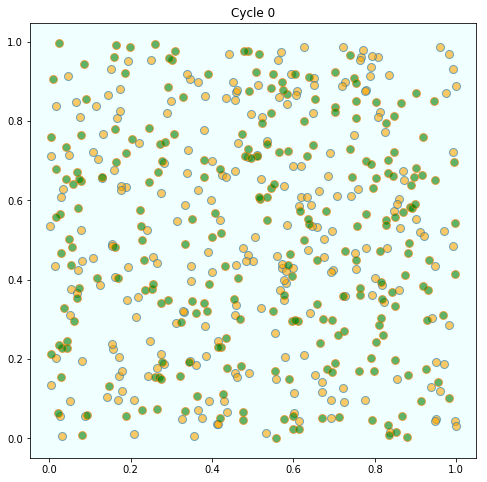

Entering loop  2


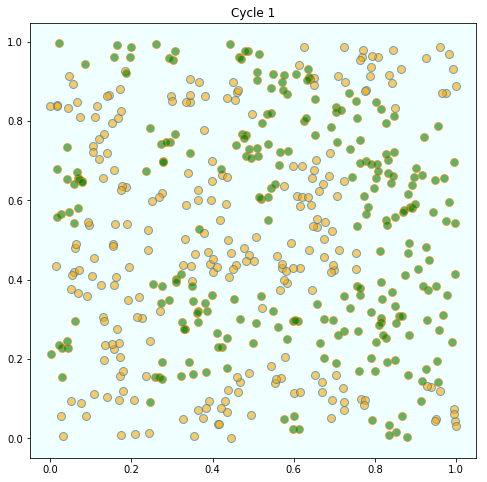

Entering loop  3


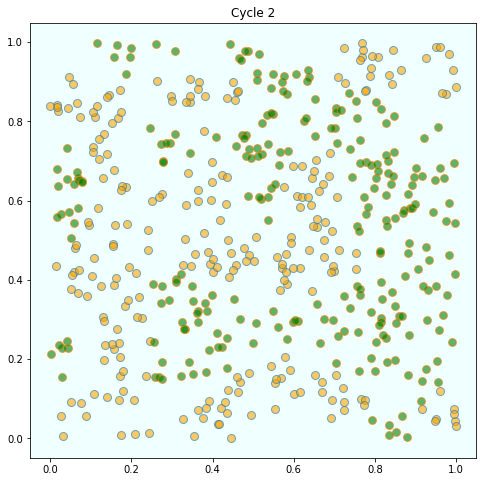

Entering loop  4


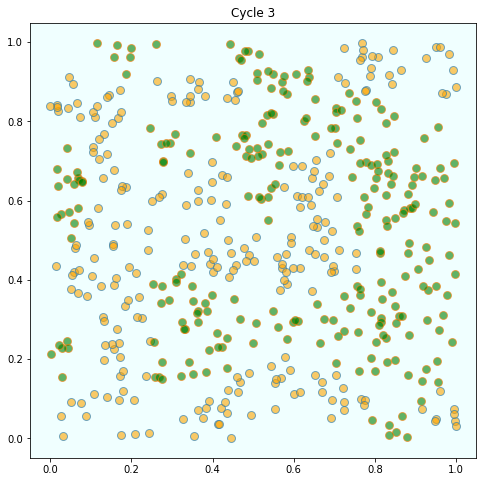

Converged, terminating.


In [2]:
seed(10)  # For reproducible random numbers

class Agent:

    def __init__(self, type):
        self.type = type
        self.draw_location()

    def draw_location(self):
        self.location = uniform(0, 1), uniform(0, 1)

    def get_distance(self, other):
        "Computes the euclidean distance between self and other agent."
        a = (self.location[0] - other.location[0])**2
        b = (self.location[1] - other.location[1])**2
        return sqrt(a + b)

    def happy(self, agents):
        "True if sufficient number of nearest neighbors are of the same type."
        distances = []
        # distances is a list of pairs (d, agent), where d is distance from
        # agent to self
        for agent in agents:
            if self != agent:
                distance = self.get_distance(agent)
                distances.append((distance, agent))
        # == Sort from smallest to largest, according to distance == #
        distances.sort()
        # == Extract the neighboring agents == #
        neighbors = [agent for d, agent in distances[:num_neighbors]]
        # == Count how many neighbors have the same type as self == #
        num_same_type = sum(self.type == agent.type for agent in neighbors)
        return num_same_type >= require_same_type

    def update(self, agents):
        "If not happy, then randomly choose new locations until happy."
        while not self.happy(agents):
            self.draw_location()


def plot_distribution(agents, cycle_num):
    "Plot the distribution of agents after cycle_num rounds of the loop."
    x_values_0, y_values_0 = [], []
    x_values_1, y_values_1 = [], []
    # == Obtain locations of each type == #
    for agent in agents:
        x, y = agent.location
        if agent.type == 0:
            x_values_0.append(x)
            y_values_0.append(y)
        else:
            x_values_1.append(x)
            y_values_1.append(y)
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_args = {'markersize': 8, 'alpha': 0.6}
    ax.set_facecolor('azure')
    ax.plot(x_values_0, y_values_0, 'o', markerfacecolor='orange', **plot_args)
    ax.plot(x_values_1, y_values_1, 'o', markerfacecolor='green', **plot_args)
    ax.set_title(f'Cycle {cycle_num-1}')
    plt.show()

# == Main == #

num_of_type_0 = 250
num_of_type_1 = 250
num_neighbors = 10      # Number of agents regarded as neighbors
require_same_type = 5   # Want at least this many neighbors to be same type

# == Create a list of agents == #
agents = [Agent(0) for i in range(num_of_type_0)]
agents.extend(Agent(1) for i in range(num_of_type_1))


count = 1
# ==  Loop until none wishes to move == #
while True:
    print('Entering loop ', count)
    plot_distribution(agents, count)
    count += 1
    no_one_moved = True
    for agent in agents:
        old_location = agent.location
        agent.update(agents)
        if agent.location != old_location:
            no_one_moved = False
    if no_one_moved:
        break

print('Converged, terminating.')

#### Lesson: A Lake Model of Employment and Unemployment

In [1]:
import numpy as np
from quantecon import MarkovChain
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
from scipy.optimize import brentq
from quantecon.distributions import BetaBinomial
from numba import jit

In [2]:
class LakeModel:
    """
    Solves the lake model and computes dynamics of unemployment stocks and
    rates.

    Parameters:
    ------------
    λ : scalar
        The job finding rate for currently unemployed workers
    α : scalar
        The dismissal rate for currently employed workers
    b : scalar
        Entry rate into the labor force
    d : scalar
        Exit rate from the labor force

    """
    def __init__(self, λ=0.283, α=0.013, b=0.0124, d=0.00822):
        self._λ, self._α, self._b, self._d = λ, α, b, d
        self.compute_derived_values()

    def compute_derived_values(self):
        # Unpack names to simplify expression
        λ, α, b, d = self._λ, self._α, self._b, self._d

        self._g = b - d
        self._A = np.array([[(1-d) * (1-λ) + b,      (1 - d) * α + b],
                            [        (1-d) * λ,   (1 - d) * (1 - α)]])

        self._A_hat = self._A / (1 + self._g)

    @property
    def g(self):
        return self._g

    @property
    def A(self):
        return self._A

    @property
    def A_hat(self):
        return self._A_hat

    @property
    def λ(self):
        return self._λ

    @λ.setter
    def λ(self, new_value):
        self._α = new_value
        self.compute_derived_values()

    @property
    def α(self):
        return self._α

    @α.setter
    def α(self, new_value):
        self._α = new_value
        self.compute_derived_values()

    @property
    def b(self):
        return self._b

    @b.setter
    def b(self, new_value):
        self._b = new_value
        self.compute_derived_values()

    @property
    def d(self):
        return self._d

    @d.setter
    def d(self, new_value):
        self._d = new_value
        self.compute_derived_values()


    def rate_steady_state(self, tol=1e-6):
        """
        Finds the steady state of the system :math:`x_{t+1} = \hat A x_{t}`

        Returns
        --------
        xbar : steady state vector of employment and unemployment rates
        """
        x = 0.5 * np.ones(2)
        error = tol + 1
        while error > tol:
            new_x = self.A_hat @ x
            error = np.max(np.abs(new_x - x))
            x = new_x
        return x

    def simulate_stock_path(self, X0, T):
        """
        Simulates the sequence of Employment and Unemployment stocks

        Parameters
        ------------
        X0 : array
            Contains initial values (E0, U0)
        T : int
            Number of periods to simulate

        Returns
        ---------
        X : iterator
            Contains sequence of employment and unemployment stocks
        """

        X = np.atleast_1d(X0)  # Recast as array just in case
        for t in range(T):
            yield X
            X = self.A @ X

    def simulate_rate_path(self, x0, T):
        """
        Simulates the sequence of employment and unemployment rates

        Parameters
        ------------
        x0 : array
            Contains initial values (e0,u0)
        T : int
            Number of periods to simulate

        Returns
        ---------
        x : iterator
            Contains sequence of employment and unemployment rates

        """
        x = np.atleast_1d(x0)  # Recast as array just in case
        for t in range(T):
            yield x
            x = self.A_hat @ x

In [3]:
lm = LakeModel()
lm.α

0.013

In [4]:
lm.A

array([[0.72350626, 0.02529314],
       [0.28067374, 0.97888686]])

In [5]:
lm.α = 2
lm.A

array([[ 0.72350626,  1.99596   ],
       [ 0.28067374, -0.99178   ]])

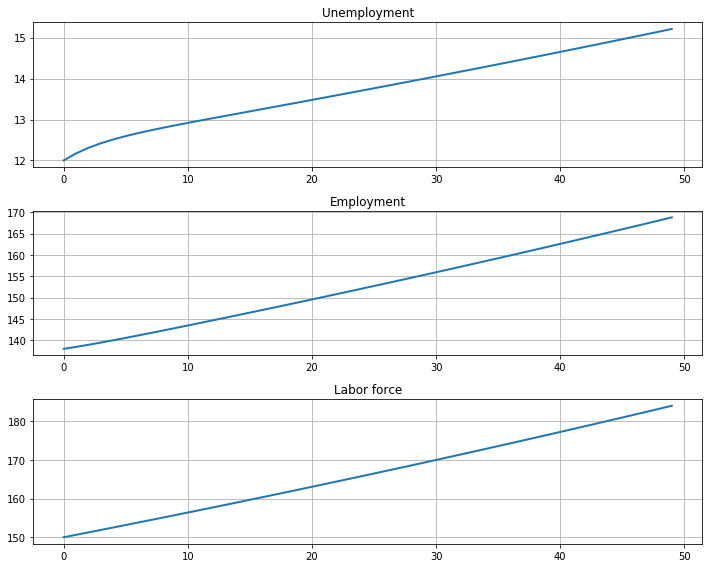

In [6]:
lm = LakeModel()
N_0 = 150      # Population
e_0 = 0.92     # Initial employment rate
u_0 = 1 - e_0  # Initial unemployment rate
T = 50         # Simulation length

U_0 = u_0 * N_0
E_0 = e_0 * N_0

fig, axes = plt.subplots(3, 1, figsize=(10, 8))
X_0 = (U_0, E_0)
X_path = np.vstack(tuple(lm.simulate_stock_path(X_0, T)))

axes[0].plot(X_path[:, 0], lw=2)
axes[0].set_title('Unemployment')

axes[1].plot(X_path[:, 1], lw=2)
axes[1].set_title('Employment')

axes[2].plot(X_path.sum(1), lw=2)
axes[2].set_title('Labor force')

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.show()

In [7]:
lm = LakeModel()
e, f = np.linalg.eigvals(lm.A_hat)
abs(e), abs(f)

(0.6953067378358462, 1.0)

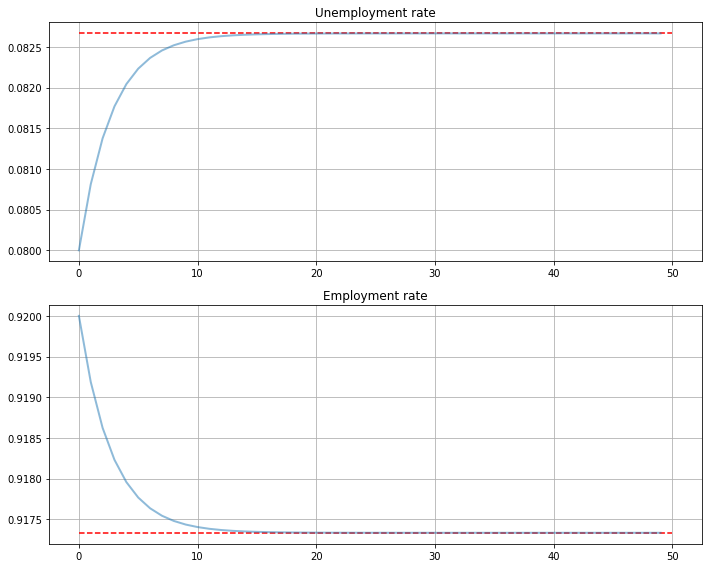

In [8]:
lm = LakeModel()
e_0 = 0.92     # Initial employment rate
u_0 = 1 - e_0  # Initial unemployment rate
T = 50         # Simulation length

xbar = lm.rate_steady_state()

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
x_0 = (u_0, e_0)
x_path = np.vstack(tuple(lm.simulate_rate_path(x_0, T)))

titles = ['Unemployment rate', 'Employment rate']

for i, title in enumerate(titles):
    axes[i].plot(x_path[:, i], lw=2, alpha=0.5)
    axes[i].hlines(xbar[i], 0, T, 'r', '--')
    axes[i].set_title(title)
    axes[i].grid()

plt.tight_layout()
plt.show()



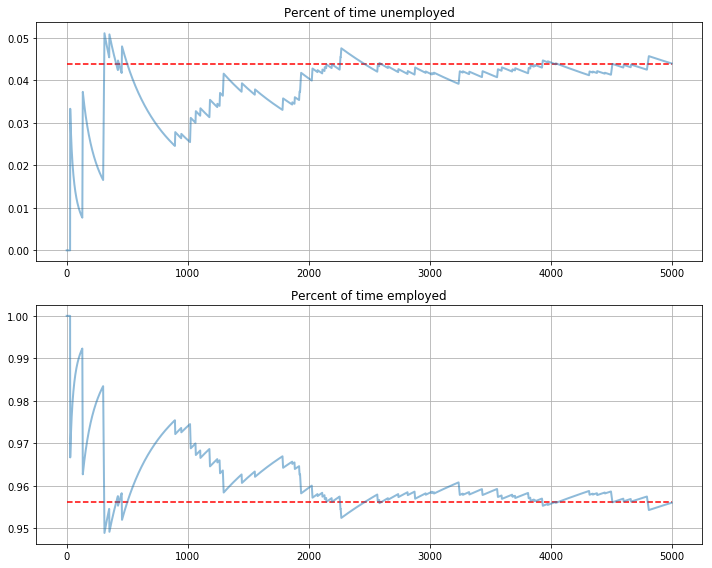

In [9]:
lm = LakeModel(d=0, b=0)
T = 5000  # Simulation length

α, λ = lm.α, lm.λ

P = [[1 - λ,        λ],
    [    α,    1 - α]]

mc = MarkovChain(P)

xbar = lm.rate_steady_state()

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
s_path = mc.simulate(T, init=1)
s_bar_e = s_path.cumsum() / range(1, T+1)
s_bar_u = 1 - s_bar_e

to_plot = [s_bar_u, s_bar_e]
titles = ['Percent of time unemployed', 'Percent of time employed']

for i, plot in enumerate(to_plot):
    axes[i].plot(plot, lw=2, alpha=0.5)
    axes[i].hlines(xbar[i], 0, T, 'r', '--')
    axes[i].set_title(titles[i])
    axes[i].grid()

plt.tight_layout()
plt.show()



In [10]:
# A default utility function

@jit
def u(c, σ):
    if c > 0:
        return (c**(1 - σ) - 1) / (1 - σ)
    else:
        return -10e6


class McCallModel:
    """
    Stores the parameters and functions associated with a given model.
    """

    def __init__(self,
                α=0.2,       # Job separation rate
                β=0.98,      # Discount rate
                γ=0.7,       # Job offer rate
                c=6.0,       # Unemployment compensation
                σ=2.0,       # Utility parameter
                w_vec=None,  # Possible wage values
                p_vec=None): # Probabilities over w_vec

        self.α, self.β, self.γ, self.c = α, β, γ, c
        self.σ = σ

        # Add a default wage vector and probabilities over the vector using
        # the beta-binomial distribution
        if w_vec is None:
            n = 60  # Number of possible outcomes for wage
            # Wages between 10 and 20
            self.w_vec = np.linspace(10, 20, n)
            a, b = 600, 400  # Shape parameters
            dist = BetaBinomial(n-1, a, b)
            self.p_vec = dist.pdf()
        else:
            self.w_vec = w_vec
            self.p_vec = p_vec

@jit
def _update_bellman(α, β, γ, c, σ, w_vec, p_vec, V, V_new, U):
    """
    A jitted function to update the Bellman equations.  Note that V_new is
    modified in place (i.e, modified by this function).  The new value of U
    is returned.

    """
    for w_idx, w in enumerate(w_vec):
        # w_idx indexes the vector of possible wages
        V_new[w_idx] = u(w, σ) + β * ((1 - α) * V[w_idx] + α * U)

    U_new = u(c, σ) + β * (1 - γ) * U + \
                    β * γ * np.sum(np.maximum(U, V) * p_vec)

    return U_new


def solve_mccall_model(mcm, tol=1e-5, max_iter=2000):
    """
    Iterates to convergence on the Bellman equations

    Parameters
    ----------
    mcm : an instance of McCallModel
    tol : float
        error tolerance
    max_iter : int
        the maximum number of iterations
    """

    V = np.ones(len(mcm.w_vec))  # Initial guess of V
    V_new = np.empty_like(V)     # To store updates to V
    U = 1                        # Initial guess of U
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        U_new = _update_bellman(mcm.α, mcm.β, mcm.γ,
                mcm.c, mcm.σ, mcm.w_vec, mcm.p_vec, V, V_new, U)
        error_1 = np.max(np.abs(V_new - V))
        error_2 = np.abs(U_new - U)
        error = max(error_1, error_2)
        V[:] = V_new
        U = U_new
        i += 1

    return V, U

In [11]:
def compute_reservation_wage(mcm, return_values=False):
    """
    Computes the reservation wage of an instance of the McCall model
    by finding the smallest w such that V(w) > U.

    If V(w) > U for all w, then the reservation wage w_bar is set to
    the lowest wage in mcm.w_vec.

    If v(w) < U for all w, then w_bar is set to np.inf.

    Parameters
    ----------
    mcm : an instance of McCallModel
    return_values : bool (optional, default=False)
        Return the value functions as well

    Returns
    -------
    w_bar : scalar
        The reservation wage

    """

    V, U = solve_mccall_model(mcm)
    w_idx = np.searchsorted(V - U, 0)

    if w_idx == len(V):
        w_bar = np.inf
    else:
        w_bar = mcm.w_vec[w_idx]

    if return_values == False:
        return w_bar
    else:
        return w_bar, V, U

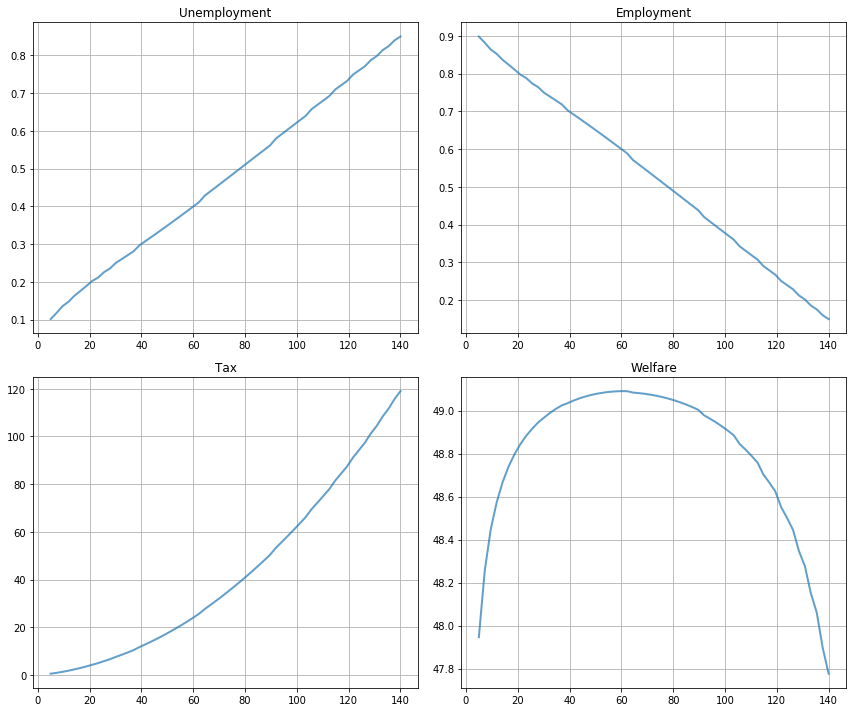

In [12]:
# Some global variables that will stay constant
α = 0.013
α_q = (1-(1-α)**3)   # Quarterly (α is monthly)
b = 0.0124
d = 0.00822
β = 0.98
γ = 1.0
σ = 2.0

# The default wage distribution --- a discretized lognormal
log_wage_mean, wage_grid_size, max_wage = 20, 200, 170
logw_dist = norm(np.log(log_wage_mean), 1)
w_vec = np.linspace(1e-8, max_wage, wage_grid_size + 1)
cdf = logw_dist.cdf(np.log(w_vec))
pdf = cdf[1:] - cdf[:-1]
p_vec = pdf / pdf.sum()
w_vec = (w_vec[1:] + w_vec[:-1]) / 2


def compute_optimal_quantities(c, τ):
    """
    Compute the reservation wage, job finding rate and value functions
    of the workers given c and τ.

    """

    mcm = McCallModel(α=α_q,
                    β=β,
                    γ=γ,
                    c=c-τ,          # Post tax compensation
                    σ=σ,
                    w_vec=w_vec-τ,  # Post tax wages
                    p_vec=p_vec)

    w_bar, V, U = compute_reservation_wage(mcm, return_values=True)
    λ = γ * np.sum(p_vec[w_vec - τ > w_bar])
    return w_bar, λ, V, U

def compute_steady_state_quantities(c, τ):
    """
    Compute the steady state unemployment rate given c and τ using optimal
    quantities from the McCall model and computing corresponding steady
    state quantities

    """
    w_bar, λ, V, U = compute_optimal_quantities(c, τ)

    # Compute steady state employment and unemployment rates
    lm = LakeModel(α=α_q, λ=λ, b=b, d=d)
    x = lm.rate_steady_state()
    u, e = x

    # Compute steady state welfare
    w = np.sum(V * p_vec * (w_vec - τ > w_bar)) / np.sum(p_vec * (w_vec -
            τ > w_bar))
    welfare = e * w + u * U

    return e, u, welfare


def find_balanced_budget_tax(c):
    """
    Find the tax level that will induce a balanced budget.

    """
    def steady_state_budget(t):
        e, u, w = compute_steady_state_quantities(c, t)
        return t - u * c

    τ = brentq(steady_state_budget, 0.0, 0.9 * c)
    return τ


# Levels of unemployment insurance we wish to study
c_vec = np.linspace(5, 140, 60)

tax_vec = []
unempl_vec = []
empl_vec = []
welfare_vec = []

for c in c_vec:
    t = find_balanced_budget_tax(c)
    e_rate, u_rate, welfare = compute_steady_state_quantities(c, t)
    tax_vec.append(t)
    unempl_vec.append(u_rate)
    empl_vec.append(e_rate)
    welfare_vec.append(welfare)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plots = [unempl_vec, empl_vec, tax_vec, welfare_vec]
titles = ['Unemployment', 'Employment', 'Tax', 'Welfare']

for ax, plot, title in zip(axes.flatten(), plots, titles):
    ax.plot(c_vec, plot, lw=2, alpha=0.7)
    ax.set_title(title)
    ax.grid()

plt.tight_layout()
plt.show()

Exercise 1

![Ex1](img/lake_1.png)

In [14]:
lm = LakeModel()
x0 = lm.rate_steady_state()
print(f"Initial Steady State: {x0}")

Initial Steady State: [0.08266806 0.91733194]


In [15]:
N0 = 100
T = 50

In [16]:
lm.lmda = 0.2

xbar = lm.rate_steady_state()  # new steady state
X_path = np.vstack(tuple(lm.simulate_stock_path(x0 * N0, T)))
x_path = np.vstack(tuple(lm.simulate_rate_path(x0, T)))
print(f"New Steady State: {xbar}")

New Steady State: [0.08266806 0.91733194]


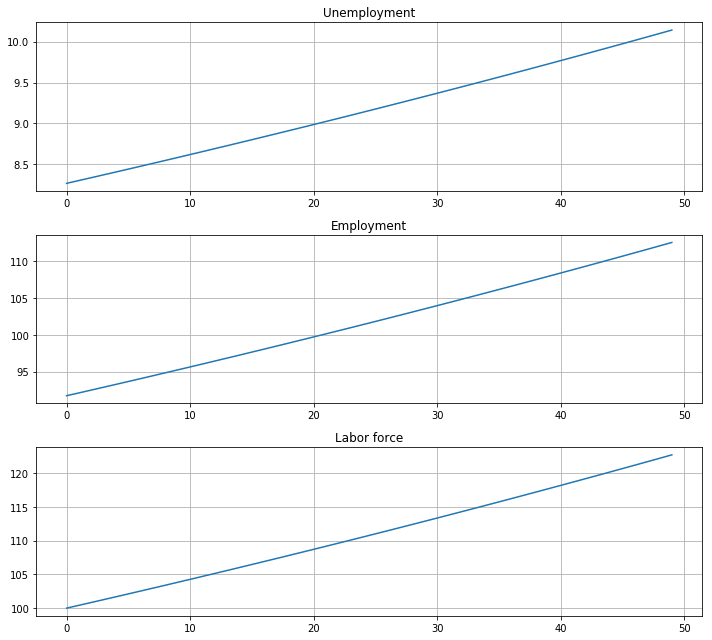

In [17]:
fig, axes = plt.subplots(3, 1, figsize=[10, 9])

axes[0].plot(X_path[:, 0])
axes[0].set_title('Unemployment')

axes[1].plot(X_path[:, 1])
axes[1].set_title('Employment')

axes[2].plot(X_path.sum(1))
axes[2].set_title('Labor force')

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.show()



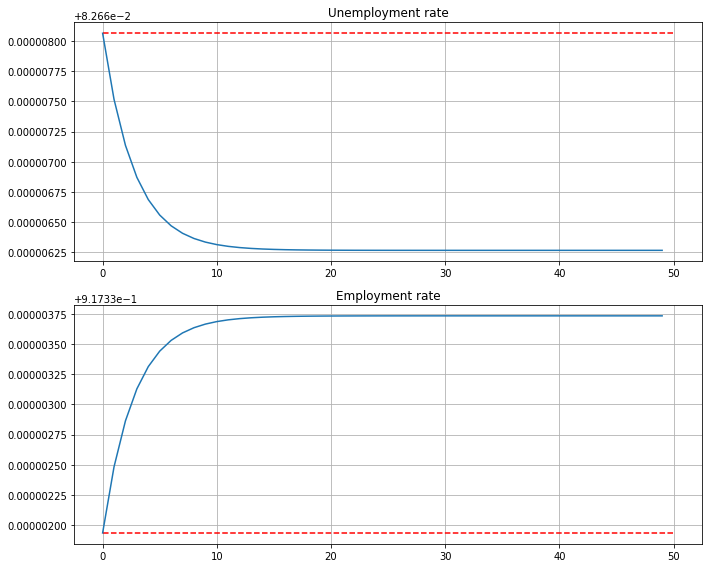

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

titles = ['Unemployment rate', 'Employment rate']

for i, title in enumerate(titles):
    axes[i].plot(x_path[:, i])
    axes[i].hlines(xbar[i], 0, T, 'r', '--')
    axes[i].set_title(title)
    axes[i].grid()

plt.tight_layout()
plt.show()

Exercise 2

![Ex2](img/lake_2.png)

In [19]:
lm = LakeModel()
x0 = lm.rate_steady_state()

In [20]:
b_hat = 0.003
T_hat = 20

In [21]:
lm.b = b_hat
# Simulate stocks
X_path1 = np.vstack(tuple(lm.simulate_stock_path(x0 * N0, T_hat)))
# Simulate rates
x_path1 = np.vstack(tuple(lm.simulate_rate_path(x0, T_hat)))

In [22]:
lm.b = 0.0124
# Simulate stocks
X_path2 = np.vstack(tuple(lm.simulate_stock_path(X_path1[-1, :2], T-T_hat+1)))
# Simulate rates
x_path2 = np.vstack(tuple(lm.simulate_rate_path(x_path1[-1, :2], T-T_hat+1)))

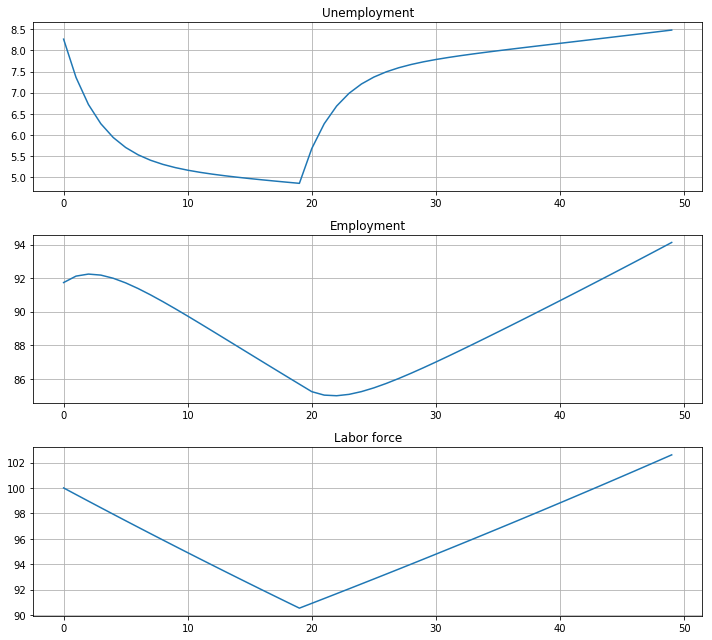

In [23]:
# note [1:] to avoid doubling period 20
x_path = np.vstack([x_path1, x_path2[1:]])
X_path = np.vstack([X_path1, X_path2[1:]])

fig, axes = plt.subplots(3, 1, figsize=[10, 9])

axes[0].plot(X_path[:, 0])
axes[0].set_title('Unemployment')

axes[1].plot(X_path[:, 1])
axes[1].set_title('Employment')

axes[2].plot(X_path.sum(1))
axes[2].set_title('Labor force')

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.show()



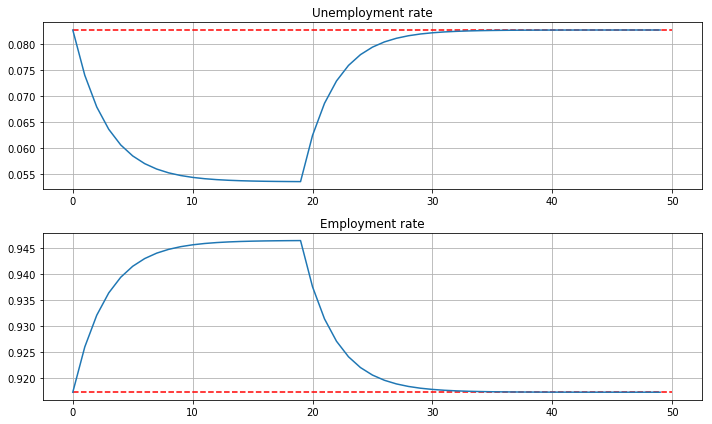

In [24]:
fig, axes = plt.subplots(2, 1, figsize=[10, 6])

titles = ['Unemployment rate', 'Employment rate']

for i, title in enumerate(titles):
    axes[i].plot(x_path[:, i])
    axes[i].hlines(x0[i], 0, T, 'r', '--')
    axes[i].set_title(title)
    axes[i].grid()

plt.tight_layout()
plt.show()

#### Lesson: Rational Expectations Equilibrium

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from quantecon import LQ

Exercise 1

![Ex1](img/rat_exp_1.png)

In [4]:
# Model parameters

a0 = 100
a1 = 0.05
β = 0.95
γ = 10.0

# Beliefs

κ0 = 95.5
κ1 = 0.95

# Formulate the LQ problem

A = np.array([[1, 0, 0], [0, κ1, κ0], [0, 0, 1]])
B = np.array([1, 0, 0])
B.shape = 3, 1
R = np.array([[0, a1/2, -a0/2], [a1/2, 0, 0], [-a0/2, 0, 0]])
Q = 0.5 * γ

# Solve for the optimal policy

lq = LQ(Q, R, A, B, beta=β)
P, F, d = lq.stationary_values()
F = F.flatten()
out1 = f"F = [{F[0]:.3f}, {F[1]:.3f}, {F[2]:.3f}]"
h0, h1, h2 = -F[2], 1 - F[0], -F[1]
out2 = f"(h0, h1, h2) = ({h0:.3f}, {h1:.3f}, {h2:.3f})"

print(out1)
print(out2)

F = [-0.000, 0.046, -96.949]
(h0, h1, h2) = (96.949, 1.000, -0.046)


Exercise 2

![Ex2](img/rat_exp_2.png)

In [5]:
candidates = ((94.0886298678, 0.923409232937),
              (93.2119845412, 0.984323478873),
              (95.0818452486, 0.952459076301))

for κ0, κ1 in candidates:

    # Form the associated law of motion
    A = np.array([[1, 0, 0], [0, κ1, κ0], [0, 0, 1]])

    # Solve the LQ problem for the firm
    lq = LQ(Q, R, A, B, beta=β)
    P, F, d = lq.stationary_values()
    F = F.flatten()
    h0, h1, h2 = -F[2], 1 - F[0], -F[1]

    # Test the equilibrium condition
    if np.allclose((κ0, κ1), (h0, h1 + h2)):
        print(f'Equilibrium pair = {κ0}, {κ1}')
        print('f(h0, h1, h2) = {h0}, {h1}, {h2}')
        break

Equilibrium pair = 95.0818452486, 0.952459076301
f(h0, h1, h2) = {h0}, {h1}, {h2}


Exercise 3

![Ex3](img/rat_exp_3.png)

In [6]:
# Formulate the planner's LQ problem

A = np.array([[1, 0], [0, 1]])
B = np.array([[1], [0]])
R = np.array([[a1 / 2, -a0 / 2], [-a0 / 2, 0]])
Q = γ / 2

# Solve for the optimal policy

lq = LQ(Q, R, A, B, beta=β)
P, F, d = lq.stationary_values()

# Print the results

F = F.flatten()
κ0, κ1 = -F[1], 1 - F[0]
print(κ0, κ1)

95.08187459215002 0.9524590627039248


Exercise 4

![Ex4](img/rat_exp_4.png)

In [7]:
A = np.array([[1, 0], [0, 1]])
B = np.array([[1], [0]])
R = np.array([[a1, -a0 / 2], [-a0 / 2, 0]])
Q = γ / 2

lq = LQ(Q, R, A, B, beta=β)
P, F, d = lq.stationary_values()

F = F.flatten()
m0, m1 = -F[1], 1 - F[0]
print(m0, m1)

73.47294403502818 0.9265270559649701


#### Lesson: Markov Perfect Equilibrium

In [1]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
"""
@authors: Chase Coleman, Thomas Sargent, John Stachurski
"""

import numpy as np
import quantecon as qe

# Parameters
a0 = 10.0
a1 = 2.0
β = 0.96
γ = 12.0

# In LQ form
A = np.eye(3)
B1 = np.array([[0.], [1.], [0.]])
B2 = np.array([[0.], [0.], [1.]])


R1 = [[      0.,     -a0 / 2,          0.],
      [-a0 / 2.,          a1,     a1 / 2.],
      [       0,     a1 / 2.,          0.]]

R2 = [[     0.,           0.,      -a0 / 2],
      [     0.,           0.,      a1 / 2.],
      [-a0 / 2,      a1 / 2.,           a1]]

Q1 = Q2 = γ
S1 = S2 = W1 = W2 = M1 = M2 = 0.0

# Solve using QE's nnash function
F1, F2, P1, P2 = qe.nnash(A, B1, B2, R1, R2, Q1, 
                          Q2, S1, S2, W1, W2, M1, 
                          M2, beta=β)

# Display policies
print("Computed policies for firm 1 and firm 2:\n")
print(f"F1 = {F1}")
print(f"F2 = {F2}")
print("\n")

Computed policies for firm 1 and firm 2:

F1 = [[-0.66846615  0.29512482  0.07584666]]
F2 = [[-0.66846615  0.07584666  0.29512482]]




In [3]:
Λ1 = A - B2 @ F2
lq1 = qe.LQ(Q1, R1, Λ1, B1, beta=β)
P1_ih, F1_ih, d = lq1.stationary_values()
F1_ih

array([[-0.66846613,  0.29512482,  0.07584666]])

In [4]:
np.allclose(F1, F1_ih)

True

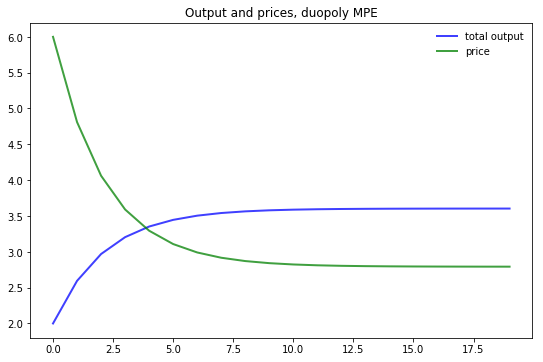

In [5]:
AF = A - B1 @ F1 - B2 @ F2
n = 20
x = np.empty((3, n))
x[:, 0] = 1, 1, 1
for t in range(n-1):
    x[:, t+1] = AF @ x[:, t]
q1 = x[1, :]
q2 = x[2, :]
q = q1 + q2       # Total output, MPE
p = a0 - a1 * q   # Price, MPE

fig, ax = plt.subplots(figsize=(9, 5.8))
ax.plot(q, 'b-', lw=2, alpha=0.75, label='total output')
ax.plot(p, 'g-', lw=2, alpha=0.75, label='price')
ax.set_title('Output and prices, duopoly MPE')
ax.legend(frameon=False)
plt.show()

Exercise 1

![Ex1](img/mark_perf_1.png)

In [6]:
# == Parameters == #
a0 = 10.0
a1 = 2.0
β = 0.96
γ = 12.0

# == In LQ form == #
A  = np.eye(3)
B1 = np.array([[0.], [1.], [0.]])
B2 = np.array([[0.], [0.], [1.]])
R1 = [[      0.,      -a0/2,          0.],
      [-a0 / 2.,         a1,     a1 / 2.],
      [       0,    a1 / 2.,          0.]]

R2 = [[     0.,          0.,     -a0 / 2],
      [     0.,          0.,     a1 / 2.],
      [-a0 / 2,     a1 / 2.,          a1]]

Q1 = Q2 = γ
S1 = S2 = W1 = W2 = M1 = M2 = 0.0

# == Solve using QE's nnash function == #
F1, F2, P1, P2 = qe.nnash(A, B1, B2, R1, R2, Q1,
                          Q2, S1, S2, W1, W2, M1,
                          M2, beta=β)

In [7]:
AF = A - B1 @ F1 - B2 @ F2
n = 20
x = np.empty((3, n))
x[:, 0] = 1, 1, 1
for t in range(n-1):
    x[:, t+1] = AF @ x[:, t]
q1 = x[1, :]
q2 = x[2, :]
q = q1 + q2       # Total output, MPE
p = a0 - a1 * q   # Price, MPE

In [8]:
R = a1
Q = γ
A = B = 1
lq_alt = qe.LQ(Q, R, A, B, beta=β)
P, F, d = lq_alt.stationary_values()
q_bar = a0 / (2.0 * a1)
qm = np.empty(n)
qm[0] = 2
x0 = qm[0] - q_bar
x = x0
for i in range(1, n):
    x = A * x - B * F * x
    qm[i] = float(x) + q_bar
pm = a0 - a1 * qm

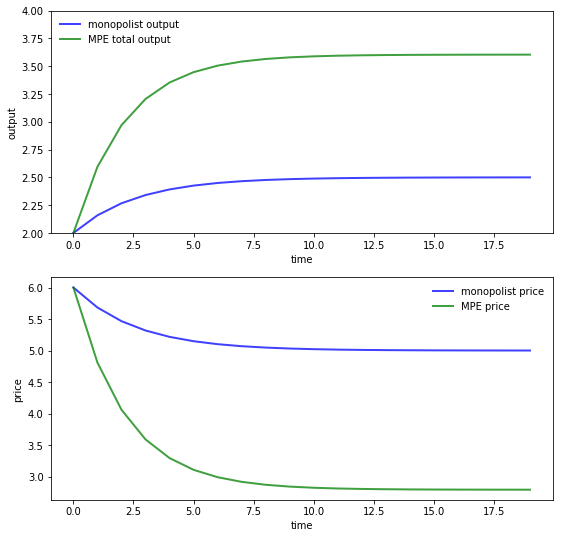

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(9, 9))

ax = axes[0]
ax.plot(qm, 'b-', lw=2, alpha=0.75, label='monopolist output')
ax.plot(q, 'g-', lw=2, alpha=0.75, label='MPE total output')
ax.set(ylabel="output", xlabel="time", ylim=(2, 4))
ax.legend(loc='upper left', frameon=0)

ax = axes[1]
ax.plot(pm, 'b-', lw=2, alpha=0.75, label='monopolist price')
ax.plot(p, 'g-', lw=2, alpha=0.75, label='MPE price')
ax.set(ylabel="price", xlabel="time")
ax.legend(loc='upper right', frameon=0)
plt.show()

Exercise 2

![Ex2](img/mark_perf_2.png)

In [16]:
δ = 0.02
D = np.array([[-1, 0.5], [0.5, -1]])
b = np.array([25, 25])
c1 = c2 = np.array([1, -2, 1])
e1 = e2 = np.array([10, 10, 3])

δ_1 = 1 - δ

In [17]:
# ==  Create matrices needed to compute the Nash feedback equilibrium == #

A = np.array([[δ_1,      0,    -δ_1 * b[0]],
              [  0,    δ_1,    -δ_1 * b[1]],
              [  0,      0,             1]])

B1 = δ_1 * np.array([[1, -D[0, 0]],
                     [0, -D[1, 0]],
                     [0,       0]])
B2 = δ_1 * np.array([[0, -D[0, 1]],
                     [1, -D[1, 1]],
                     [0,       0]])

R1 = -np.array([[0.5 * c1[2],     0,    0.5 * c1[1]],
                [          0,     0,              0],
                [0.5 * c1[1],     0,         c1[0]]])
R2 = -np.array([[0,               0,              0],
                [0,     0.5 * c2[2],    0.5 * c2[1]],
                [0,     0.5 * c2[1],         c2[0]]])

Q1 = np.array([[-0.5 * e1[2], 0], [0, D[0, 0]]])
Q2 = np.array([[-0.5 * e2[2], 0], [0, D[1, 1]]])

S1 = np.zeros((2, 2))
S2 = np.copy(S1)

W1 = np.array([[           0,             0],
               [           0,             0],
               [-0.5 * e1[1],    b[0] / 2.]])
W2 = np.array([[           0,             0],
               [           0,             0],
               [-0.5 * e2[1],    b[1] / 2.]])

M1 = np.array([[0, 0], [0, D[0, 1] / 2.]])
M2 = np.copy(M1)

In [18]:
F1, F2, P1, P2 = qe.nnash(A, B1, B2, R1,
                          R2, Q1, Q2, S1,
                          S2, W1, W2, M1, M2)

print("\nFirm 1's feedback rule:\n")
print(F1)

print("\nFirm 2's feedback rule:\n")
print(F2)


Firm 1's feedback rule:

[[ 2.43666582e-01  2.72360627e-02 -6.82788293e+00]
 [ 3.92370734e-01  1.39696451e-01 -3.77341073e+01]]

Firm 2's feedback rule:

[[ 2.72360627e-02  2.43666582e-01 -6.82788293e+00]
 [ 1.39696451e-01  3.92370734e-01 -3.77341073e+01]]


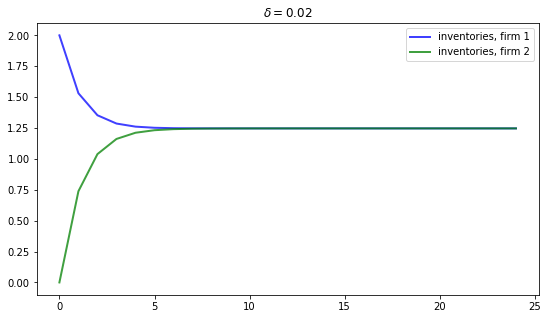

In [19]:
AF = A - B1 @ F1 - B2 @ F2
n = 25
x = np.empty((3, n))
x[:, 0] = 2, 0, 1
for t in range(n-1):
    x[:, t+1] = AF @ x[:, t]
I1 = x[0, :]
I2 = x[1, :]
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(I1, 'b-', lw=2, alpha=0.75, label='inventories, firm 1')
ax.plot(I2, 'g-', lw=2, alpha=0.75, label='inventories, firm 2')
ax.set_title(rf'$\delta = {δ}$')
ax.legend()
plt.show()

#### Lesson: Robust Markov Perfect Equilibrium

In [1]:
import numpy as np
import quantecon as qe
from scipy.linalg import solve
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
"""
@authors: Chase Coleman, Thomas Sargent, John Stachurski
"""

import numpy as np
import quantecon as qe

# Parameters
a0 = 10.0
a1 = 2.0
β = 0.96
γ = 12.0

# In LQ form
A = np.eye(3)
B1 = np.array([[0.], [1.], [0.]])
B2 = np.array([[0.], [0.], [1.]])


R1 = [[      0.,     -a0 / 2,          0.],
      [-a0 / 2.,          a1,     a1 / 2.],
      [       0,     a1 / 2.,          0.]]

R2 = [[     0.,           0.,      -a0 / 2],
      [     0.,           0.,      a1 / 2.],
      [-a0 / 2,      a1 / 2.,           a1]]

Q1 = Q2 = γ
S1 = S2 = W1 = W2 = M1 = M2 = 0.0

# Solve using QE's nnash function
F1, F2, P1, P2 = qe.nnash(A, B1, B2, R1, R2, Q1, 
                          Q2, S1, S2, W1, W2, M1, 
                          M2, beta=β)

# Display policies
print("Computed policies for firm 1 and firm 2:\n")
print(f"F1 = {F1}")
print(f"F2 = {F2}")
print("\n")

Computed policies for firm 1 and firm 2:

F1 = [[-0.66846615  0.29512482  0.07584666]]
F2 = [[-0.66846615  0.07584666  0.29512482]]




In [3]:
def nnash_robust(A, C, B1, B2, R1, R2, Q1, Q2, S1, S2, W1, W2, M1, M2,
                 θ1, θ2, beta=1.0, tol=1e-8, max_iter=1000):

    """
    Compute the limit of a Nash linear quadratic dynamic game with
    robustness concern.

    In this problem, player i minimizes
    .. math::
        \sum_{t=0}^{\infty}
        \left\{
            x_t' r_i x_t + 2 x_t' w_i
            u_{it} +u_{it}' q_i u_{it} + u_{jt}' s_i u_{jt} + 2 u_{jt}'
            m_i u_{it}
        \right\}
    subject to the law of motion
    .. math::
        x_{it+1} = A x_t + b_1 u_{1t} + b_2 u_{2t} + C w_{it+1}
    and a perceived control law :math:`u_j(t) = - f_j x_t` for the other
    player.

    The player i also concerns about the model misspecification,
    and maximizes
    .. math::
        \sum_{t=0}^{\infty}
        \left\{
            \beta^{t+1} \theta_{i} w_{it+1}'w_{it+1}
        \right\}

    The solution computed in this routine is the :math:`f_i` and
    :math:`P_i` of the associated double optimal linear regulator
    problem.

    Parameters
    ----------
    A : scalar(float) or array_like(float)
        Corresponds to the MPE equations, should be of size (n, n)
    C : scalar(float) or array_like(float)
        As above, size (n, c), c is the size of w
    B1 : scalar(float) or array_like(float)
        As above, size (n, k_1)
    B2 : scalar(float) or array_like(float)
        As above, size (n, k_2)
    R1 : scalar(float) or array_like(float)
        As above, size (n, n)
    R2 : scalar(float) or array_like(float)
        As above, size (n, n)
    Q1 : scalar(float) or array_like(float)
        As above, size (k_1, k_1)
    Q2 : scalar(float) or array_like(float)
        As above, size (k_2, k_2)
    S1 : scalar(float) or array_like(float)
        As above, size (k_1, k_1)
    S2 : scalar(float) or array_like(float)
        As above, size (k_2, k_2)
    W1 : scalar(float) or array_like(float)
        As above, size (n, k_1)
    W2 : scalar(float) or array_like(float)
        As above, size (n, k_2)
    M1 : scalar(float) or array_like(float)
        As above, size (k_2, k_1)
    M2 : scalar(float) or array_like(float)
        As above, size (k_1, k_2)
    θ1 : scalar(float)
            Robustness parameter of player 1
    θ2 : scalar(float)
            Robustness parameter of player 2
    beta : scalar(float), optional(default=1.0)
          Discount factor
    tol : scalar(float), optional(default=1e-8)
         This is the tolerance level for convergence
    max_iter : scalar(int), optional(default=1000)
        This is the maximum number of iterations allowed

    Returns
    -------
    F1 : array_like, dtype=float, shape=(k_1, n)
        Feedback law for agent 1
    F2 : array_like, dtype=float, shape=(k_2, n)
        Feedback law for agent 2
    P1 : array_like, dtype=float, shape=(n, n)
        The steady-state solution to the associated discrete matrix
        Riccati equation for agent 1
    P2 : array_like, dtype=float, shape=(n, n)
        The steady-state solution to the associated discrete matrix
        Riccati equation for agent 2
    """

    # Unload parameters and make sure everything is a matrix
    params = A, C, B1, B2, R1, R2, Q1, Q2, S1, S2, W1, W2, M1, M2
    params = map(np.asmatrix, params)
    A, C, B1, B2, R1, R2, Q1, Q2, S1, S2, W1, W2, M1, M2 = params


    # Multiply A, B1, B2 by sqrt(β) to enforce discounting
    A, B1, B2 = [np.sqrt(β) * x for x in (A, B1, B2)]

    # Initial values
    n = A.shape[0]
    k_1 = B1.shape[1]
    k_2 = B2.shape[1]

    v1 = np.eye(k_1)
    v2 = np.eye(k_2)
    P1 = np.eye(n) * 1e-5
    P2 = np.eye(n) * 1e-5
    F1 = np.random.randn(k_1, n)
    F2 = np.random.randn(k_2, n)


    for it in range(max_iter):
        # Update
        F10 = F1
        F20 = F2

        I = np.eye(C.shape[1])

        # D1(P1)
        # Note: INV1 may not be solved if the matrix is singular
        INV1 = solve(θ1 * I - C.T @ P1 @ C, I)
        D1P1 =  P1 + P1 @ C @ INV1 @ C.T @ P1

        # D2(P2)
        # Note: INV2 may not be solved if the matrix is singular
        INV2 = solve(θ2 * I - C.T @ P2 @ C, I)
        D2P2 =  P2 + P2 @ C @ INV2 @ C.T @ P2

        G2 = solve(Q2 + B2.T @ D2P2 @ B2, v2)
        G1 = solve(Q1 + B1.T @ D1P1 @ B1, v1)
        H2 = G2 @ B2.T @ D2P2
        H1 = G1 @ B1.T @ D1P1

        # Break up the computation of F1, F2
        F1_left = v1 - (H1 @ B2 + G1 @ M1.T) @ (H2 @ B1 + G2 @ M2.T)
        F1_right = H1 @ A + G1 @ W1.T - \
                   (H1 @ B2 + G1 @ M1.T) @ (H2 @ A + G2 @ W2.T)
        F1 = solve(F1_left, F1_right)
        F2 = H2 @ A + G2 @ W2.T - (H2 @ B1 + G2 @ M2.T) @ F1

        Λ1 = A - B2 @ F2
        Λ2 = A - B1 @ F1
        Π1 = R1 + F2.T @ S1 @ F2
        Π2 = R2 + F1.T @ S2 @ F1
        Γ1 = W1.T - M1.T @ F2
        Γ2 = W2.T - M2.T @ F1

        # Compute P1 and P2
        P1 = Π1 - (B1.T @ D1P1 @ Λ1 + Γ1).T @ F1 + \
             Λ1.T @ D1P1 @ Λ1
        P2 = Π2 - (B2.T @ D2P2 @ Λ2 + Γ2).T @ F2 + \
             Λ2.T @ D2P2 @ Λ2

        dd = np.max(np.abs(F10 - F1)) + np.max(np.abs(F20 - F2))

        if dd < tol:  # success!
            break

    else:
        raise ValueError(f'No convergence: Iteration limit of {maxiter} \
            reached in nnash')

    return F1, F2, P1, P2

In [4]:
# Parameters
a0 = 10.0
a1 = 2.0
β = 0.96
γ = 12.0


# In LQ form
A = np.eye(3)
B1 = np.array([[0.], [1.], [0.]])
B2 = np.array([[0.], [0.], [1.]])


R1 = [[      0.,     -a0 / 2,          0.],
      [-a0 / 2.,          a1,     a1 / 2.],
      [       0,     a1 / 2.,          0.]]

R2 = [[     0.,           0.,      -a0 / 2],
      [     0.,           0.,      a1 / 2.],
      [-a0 / 2,      a1 / 2.,           a1]]

Q1 = Q2 = γ
S1 = S2 = W1 = W2 = M1 = M2 = 0.0

In [5]:
# Solve using QE's nnash function
F1, F2, P1, P2 = qe.nnash(A, B1, B2, R1, R2, Q1,
                          Q2, S1, S2, W1, W2, M1,
                          M2, beta=β)

# Solve using nnash_robust
F1r, F2r, P1r, P2r = nnash_robust(A, np.zeros((3, 1)), B1, B2, R1, R2, Q1,
                                  Q2, S1, S2, W1, W2, M1, M2, 1e-10,
                                  1e-10, beta=β)

print('F1 and F1r should be the same: ', np.allclose(F1, F1r))
print('F2 and F2r should be the same: ', np.allclose(F1, F1r))
print('P1 and P1r should be the same: ', np.allclose(P1, P1r))
print('P2 and P2r should be the same: ', np.allclose(P1, P1r))

F1 and F1r should be the same:  True
F2 and F2r should be the same:  True
P1 and P1r should be the same:  True
P2 and P2r should be the same:  True


In [6]:
# Robustness parameters and matrix
C = np.asmatrix([[0], [0.01], [0.01]])
θ1 = 0.02
θ2 = 0.04
n = 20


# Solve using nnash_robust
F1r, F2r, P1r, P2r = nnash_robust(A, C, B1, B2, R1, R2, Q1,
                                  Q2, S1, S2, W1, W2, M1, M2,
                                  θ1, θ2, beta=β)



# MPE output and price
AF = A - B1 @ F1 - B2 @ F2
x = np.empty((3, n))
x[:, 0] = 1, 1, 1
for t in range(n - 1):
    x[:, t + 1] = AF @ x[:, t]
q1 = x[1, :]
q2 = x[2, :]
q = q1 + q2       # Total output, MPE
p = a0 - a1 * q   # Price, MPE


# RMPE output and price
AO = A - B1 @ F1r - B2 @ F2r
xr = np.empty((3, n))
xr[:, 0] = 1, 1, 1
for t in range(n - 1):
    xr[:, t+1] = AO @ xr[:, t]
qr1 = xr[1, :]
qr2 = xr[2, :]
qr = qr1 + qr2      # Total output, RMPE
pr = a0 - a1 * qr   # Price, RMPE

# RMPE heterogeneous beliefs output and price
I = np.eye(C.shape[1])
INV1 = solve(θ1 * I - C.T @ P1 @ C, I)
K1 =  P1 @ C @ INV1 @ C.T @ P1 @ AO
AOCK1 = AO + C.T @ K1

INV2 = solve(θ2 * I - C.T @ P2 @ C, I)
K2 =  P2 @ C @ INV2 @ C.T @ P2 @ AO
AOCK2 = AO + C.T @ K2
xrp1 = np.empty((3, n))
xrp2 = np.empty((3, n))
xrp1[:, 0] = 1, 1, 1
xrp2[:, 0] = 1, 1, 1
for t in range(n - 1):
    xrp1[:, t + 1] = AOCK1 @ xrp1[:, t]
    xrp2[:, t + 1] = AOCK2 @ xrp2[:, t]
qrp11 = xrp1[1, :]
qrp12 = xrp1[2, :]
qrp21 = xrp2[1, :]
qrp22 = xrp2[2, :]
qrp1 = qrp11 + qrp12       # Total output, RMPE from player 1's belief
qrp2 = qrp21 + qrp22       # Total output, RMPE from player 2's belief
prp1 = a0 - a1 * qrp1      # Price, RMPE from player 1's belief
prp2 = a0 - a1 * qrp2      # Price, RMPE from player 2's belief

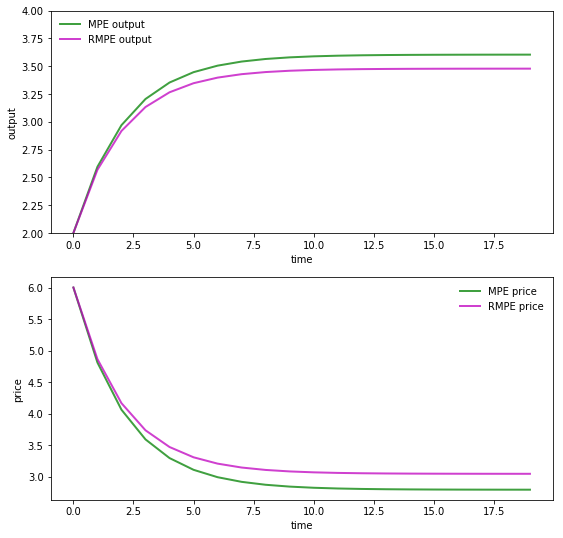

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(9, 9))

ax = axes[0]
ax.plot(q, 'g-', lw=2, alpha=0.75, label='MPE output')
ax.plot(qr, 'm-', lw=2, alpha=0.75, label='RMPE output')
ax.set(ylabel="output", xlabel="time", ylim=(2, 4))
ax.legend(loc='upper left', frameon=0)

ax = axes[1]
ax.plot(p, 'g-', lw=2, alpha=0.75, label='MPE price')
ax.plot(pr, 'm-', lw=2, alpha=0.75, label='RMPE price')
ax.set(ylabel="price", xlabel="time")
ax.legend(loc='upper right', frameon=0)
plt.show()

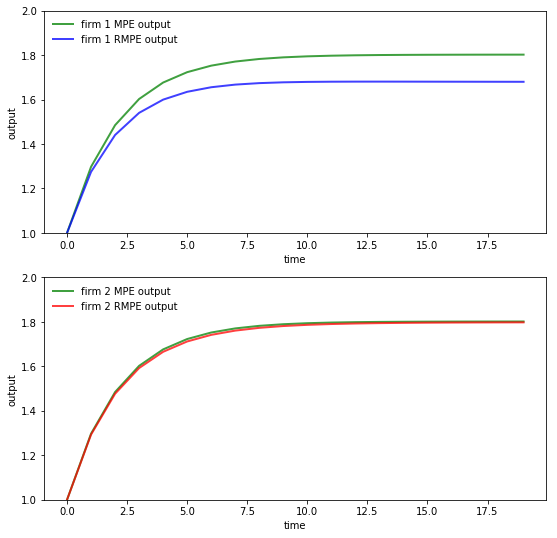

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(9, 9))

ax = axes[0]
ax.plot(q1, 'g-', lw=2, alpha=0.75, label='firm 1 MPE output')
ax.plot(qr1, 'b-', lw=2, alpha=0.75, label='firm 1 RMPE output')
ax.set(ylabel="output", xlabel="time", ylim=(1, 2))
ax.legend(loc='upper left', frameon=0)

ax = axes[1]
ax.plot(q2, 'g-', lw=2, alpha=0.75, label='firm 2 MPE output')
ax.plot(qr2, 'r-', lw=2, alpha=0.75, label='firm 2 RMPE output')
ax.set(ylabel="output", xlabel="time", ylim=(1, 2))
ax.legend(loc='upper left', frameon=0)
plt.show()



In [9]:
print('Baseline Robust transition matrix AO is: \n', np.round(AO, 3))
print('Player 1\'s worst-case transition matrix AOCK1 is: \n', \
np.round(AOCK1, 3))
print('Player 2\'s worst-case transition matrix AOCK2 is: \n', \
np.round(AOCK2, 3))

Baseline Robust transition matrix AO is: 
 [[ 1.     0.     0.   ]
 [ 0.666  0.682 -0.074]
 [ 0.671 -0.071  0.694]]
Player 1's worst-case transition matrix AOCK1 is: 
 [[ 0.998  0.002  0.   ]
 [ 0.664  0.685 -0.074]
 [ 0.669 -0.069  0.694]]
Player 2's worst-case transition matrix AOCK2 is: 
 [[ 0.999  0.     0.001]
 [ 0.665  0.683 -0.073]
 [ 0.67  -0.071  0.695]]


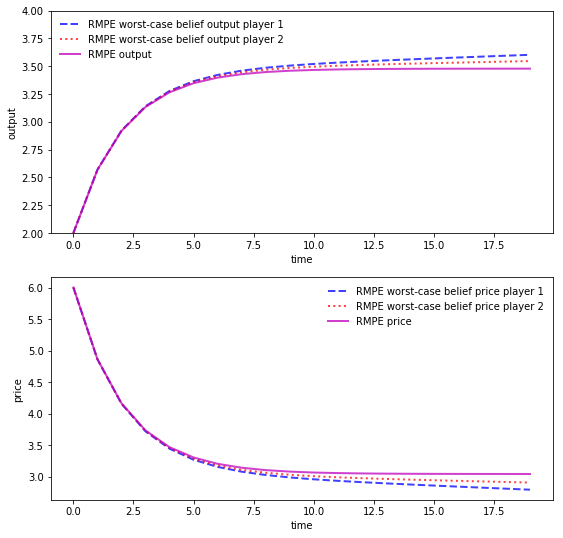

In [10]:
# == Plot == #
fig, axes = plt.subplots(2, 1, figsize=(9, 9))

ax = axes[0]
ax.plot(qrp1, 'b--', lw=2, alpha=0.75,
    label='RMPE worst-case belief output player 1')
ax.plot(qrp2, 'r:', lw=2, alpha=0.75,
    label='RMPE worst-case belief output player 2')
ax.plot(qr, 'm-', lw=2, alpha=0.75, label='RMPE output')
ax.set(ylabel="output", xlabel="time", ylim=(2, 4))
ax.legend(loc='upper left', frameon=0)

ax = axes[1]
ax.plot(prp1, 'b--', lw=2, alpha=0.75,
    label='RMPE worst-case belief price player 1')
ax.plot(prp2, 'r:', lw=2, alpha=0.75,
    label='RMPE worst-case belief price player 2')
ax.plot(pr, 'm-', lw=2, alpha=0.75, label='RMPE price')
ax.set(ylabel="price", xlabel="time")
ax.legend(loc='upper right', frameon=0)
plt.show()

#### Lesson: Uncertainty Traps

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import itertools

In [12]:
class UncertaintyTrapEcon:

    def __init__(self,
                a=1.5,          # Risk aversion
                γ_x=0.5,        # Production shock precision
                ρ=0.99,         # Correlation coefficient for θ
                σ_θ=0.5,        # Standard dev of θ shock
                num_firms=100,  # Number of firms
                σ_F=1.5,        # Standard dev of fixed costs
                c=-420,         # External opportunity cost
                μ_init=0,       # Initial value for μ
                γ_init=4,       # Initial value for γ
                θ_init=0):      # Initial value for θ

        # == Record values == #
        self.a, self.γ_x, self.ρ, self.σ_θ = a, γ_x, ρ, σ_θ
        self.num_firms, self.σ_F, self.c, = num_firms, σ_F, c
        self.σ_x = np.sqrt(1/γ_x)

        # == Initialize states == #
        self.γ, self.μ, self.θ = γ_init, μ_init, θ_init

    def ψ(self, F):
        temp1 = -self.a * (self.μ - F)
        temp2 = self.a**2 * (1/self.γ + 1/self.γ_x) / 2
        return (1 / self.a) * (1 - np.exp(temp1 + temp2)) - self.c

    def update_beliefs(self, X, M):
        """
        Update beliefs (μ, γ) based on aggregates X and M.
        """
        # Simplify names
        γ_x, ρ, σ_θ = self.γ_x, self.ρ, self.σ_θ
        # Update μ
        temp1 = ρ * (self.γ * self.μ + M * γ_x * X)
        temp2 = self.γ + M * γ_x
        self.μ = temp1 / temp2
        # Update γ
        self.γ = 1 / (ρ**2 / (self.γ + M * γ_x) + σ_θ**2)

    def update_θ(self, w):
        """
        Update the fundamental state θ given shock w.
        """
        self.θ = self.ρ * self.θ + self.σ_θ * w

    def gen_aggregates(self):
        """
        Generate aggregates based on current beliefs (μ, γ). This
        is a simulation step that depends on the draws for F.
        """
        F_vals = self.σ_F * np.random.randn(self.num_firms)
        M = np.sum(self.ψ(F_vals) > 0)  # Counts number of active firms
        if M > 0:
            x_vals = self.θ + self.σ_x * np.random.randn(M)
            X = x_vals.mean()
        else:
            X = 0
        return X, M

Exercise 1

![Ex1](img/uncert_traps_1.png)

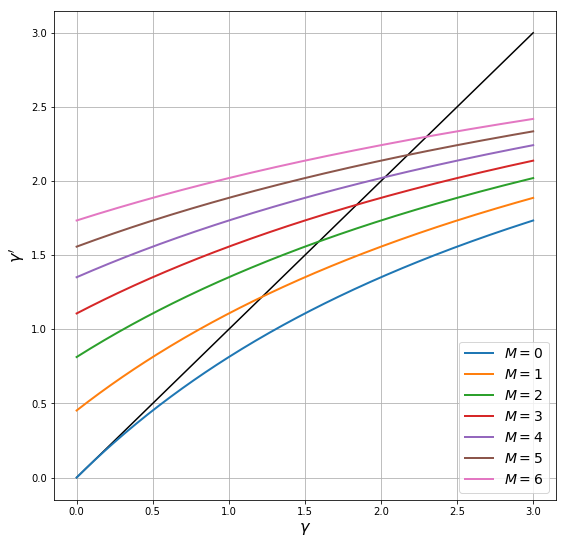

In [13]:
econ = UncertaintyTrapEcon()
ρ, σ_θ, γ_x = econ.ρ, econ.σ_θ, econ.γ_x    # Simplify names
γ = np.linspace(1e-10, 3, 200)              # γ grid
fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(γ, γ, 'k-')                         # 45 degree line

for M in range(7):
    γ_next = 1 / (ρ**2 / (γ + M * γ_x) + σ_θ**2)
    label_string = f"$M = {M}$"
    ax.plot(γ, γ_next, lw=2, label=label_string)
ax.legend(loc='lower right', fontsize=14)
ax.set_xlabel(r'$\gamma$', fontsize=16)
ax.set_ylabel(r"$\gamma'$", fontsize=16)
ax.grid()
plt.show()

In [14]:
sim_length=2000

μ_vec = np.empty(sim_length)
θ_vec = np.empty(sim_length)
γ_vec = np.empty(sim_length)
X_vec = np.empty(sim_length)
M_vec = np.empty(sim_length)

μ_vec[0] = econ.μ
γ_vec[0] = econ.γ
θ_vec[0] = 0

w_shocks = np.random.randn(sim_length)

for t in range(sim_length-1):
    X, M = econ.gen_aggregates()
    X_vec[t] = X
    M_vec[t] = M

    econ.update_beliefs(X, M)
    econ.update_θ(w_shocks[t])

    μ_vec[t+1] = econ.μ
    γ_vec[t+1] = econ.γ
    θ_vec[t+1] = econ.θ

# Record final values of aggregates
X, M = econ.gen_aggregates()
X_vec[-1] = X
M_vec[-1] = M

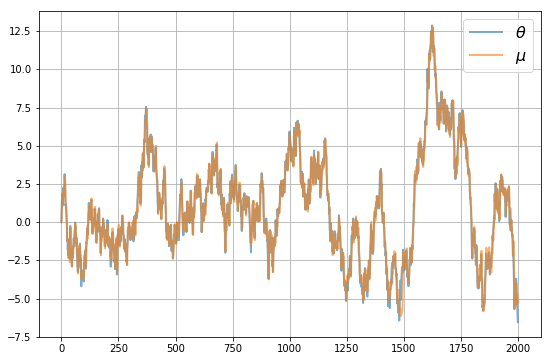

In [15]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(range(sim_length), θ_vec, alpha=0.6, lw=2, label=r"$\theta$")
ax.plot(range(sim_length), μ_vec, alpha=0.6, lw=2, label=r"$\mu$")
ax.legend(fontsize=16)
ax.grid()
plt.show()

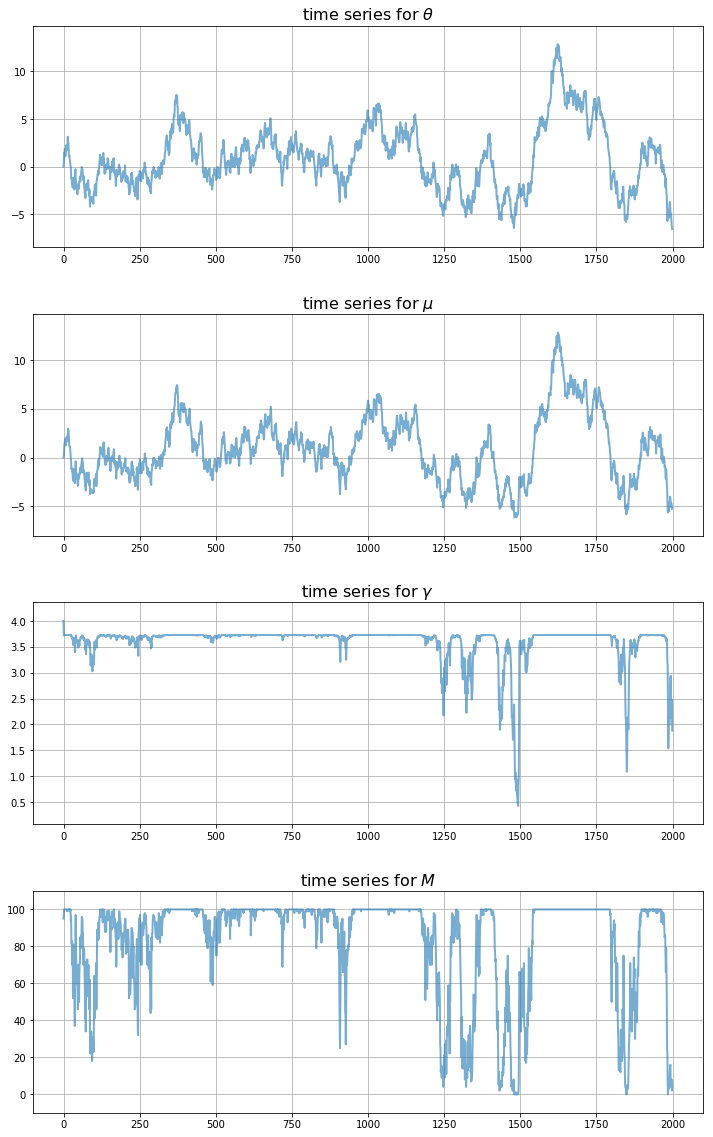

In [16]:
fig, axes = plt.subplots(4, 1, figsize=(12, 20))
# Add some spacing
fig.subplots_adjust(hspace=0.3)

series = (θ_vec, μ_vec, γ_vec, M_vec)
names = r'$\theta$', r'$\mu$', r'$\gamma$', r'$M$'

for ax, vals, name in zip(axes, series, names):
    # Determine suitable y limits
    s_max, s_min = max(vals), min(vals)
    s_range = s_max - s_min
    y_max = s_max + s_range * 0.1
    y_min = s_min - s_range * 0.1
    ax.set_ylim(y_min, y_max)
    # Plot series
    ax.plot(range(sim_length), vals, alpha=0.6, lw=2)
    ax.set_title(f"time series for {name}", fontsize=16)
    ax.grid()

plt.show()



#### Lesson: The Aiyagari Model

In [17]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon.markov import DiscreteDP
from numba import jit

In [18]:
class Household:
    """
    This class takes the parameters that define a household asset accumulation
    problem and computes the corresponding reward and transition matrices R
    and Q required to generate an instance of DiscreteDP, and thereby solve
    for the optimal policy.

    Comments on indexing: We need to enumerate the state space S as a sequence
    S = {0, ..., n}.  To this end, (a_i, z_i) index pairs are mapped to s_i
    indices according to the rule

        s_i = a_i * z_size + z_i

    To invert this map, use

        a_i = s_i // z_size  (integer division)
        z_i = s_i % z_size

    """


    def __init__(self,
                r=0.01,                      # Interest rate
                w=1.0,                       # Wages
                β=0.96,                      # Discount factor
                a_min=1e-10,
                Π=[[0.9, 0.1], [0.1, 0.9]],  # Markov chain
                z_vals=[0.1, 1.0],           # Exogenous states
                a_max=18,
                a_size=200):

        # Store values, set up grids over a and z
        self.r, self.w, self.β = r, w, β
        self.a_min, self.a_max, self.a_size = a_min, a_max, a_size

        self.Π = np.asarray(Π)
        self.z_vals = np.asarray(z_vals)
        self.z_size = len(z_vals)

        self.a_vals = np.linspace(a_min, a_max, a_size)
        self.n = a_size * self.z_size

        # Build the array Q
        self.Q = np.zeros((self.n, a_size, self.n))
        self.build_Q()

        # Build the array R
        self.R = np.empty((self.n, a_size))
        self.build_R()

    def set_prices(self, r, w):
        """
        Use this method to reset prices. Calling the method will trigger a
        re-build of R.
        """
        self.r, self.w = r, w
        self.build_R()

    def build_Q(self):
        populate_Q(self.Q, self.a_size, self.z_size, self.Π)

    def build_R(self):
        self.R.fill(-np.inf)
        populate_R(self.R,
                self.a_size,
                self.z_size,
                self.a_vals,
                self.z_vals,
                self.r,
                self.w)


# Do the hard work using JIT-ed functions

@jit(nopython=True)
def populate_R(R, a_size, z_size, a_vals, z_vals, r, w):
    n = a_size * z_size
    for s_i in range(n):
        a_i = s_i // z_size
        z_i = s_i % z_size
        a = a_vals[a_i]
        z = z_vals[z_i]
        for new_a_i in range(a_size):
            a_new = a_vals[new_a_i]
            c = w * z + (1 + r) * a - a_new
            if c > 0:
                R[s_i, new_a_i] = np.log(c)  # Utility

@jit(nopython=True)
def populate_Q(Q, a_size, z_size, Π):
    n = a_size * z_size
    for s_i in range(n):
        z_i = s_i % z_size
        for a_i in range(a_size):
            for next_z_i in range(z_size):
                Q[s_i, a_i, a_i*z_size + next_z_i] = Π[z_i, next_z_i]


@jit(nopython=True)
def asset_marginal(s_probs, a_size, z_size):
    a_probs = np.zeros(a_size)
    for a_i in range(a_size):
        for z_i in range(z_size):
            a_probs[a_i] += s_probs[a_i*z_size + z_i]
    return a_probs

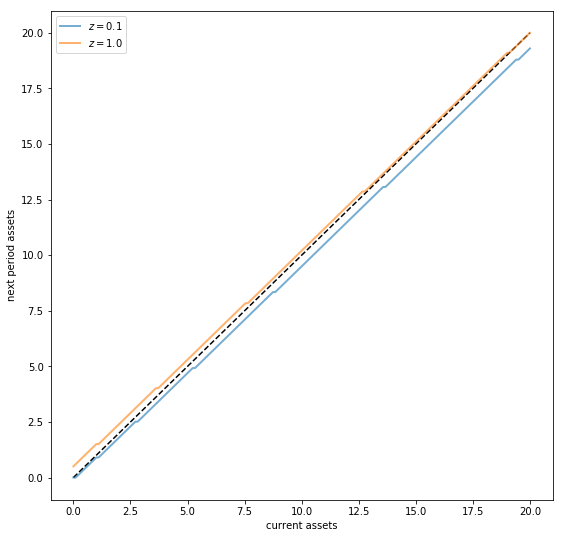

In [19]:
# Example prices
r = 0.03
w = 0.956

# Create an instance of Household
am = Household(a_max=20, r=r, w=w)

# Use the instance to build a discrete dynamic program
am_ddp = DiscreteDP(am.R, am.Q, am.β)

# Solve using policy function iteration
results = am_ddp.solve(method='policy_iteration')

# Simplify names
z_size, a_size = am.z_size, am.a_size
z_vals, a_vals = am.z_vals, am.a_vals
n = a_size * z_size

# Get all optimal actions across the set of a indices with z fixed in each row
a_star = np.empty((z_size, a_size))
for s_i in range(n):
    a_i = s_i // z_size
    z_i = s_i % z_size
    a_star[z_i, a_i] = a_vals[results.sigma[s_i]]

fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(a_vals, a_vals, 'k--')  # 45 degrees
for i in range(z_size):
    lb = f'$z = {z_vals[i]:.2}$'
    ax.plot(a_vals, a_star[i, :], lw=2, alpha=0.6, label=lb)
    ax.set_xlabel('current assets')
    ax.set_ylabel('next period assets')
ax.legend(loc='upper left')

plt.show()



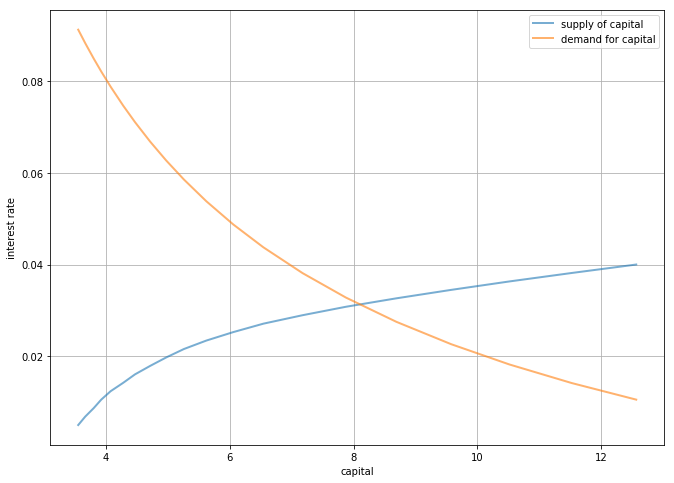

In [20]:
A = 1.0
N = 1.0
α = 0.33
β = 0.96
δ = 0.05


def r_to_w(r):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    return A * (1 - α) * (A * α / (r + δ))**(α / (1 - α))

def rd(K):
    """
    Inverse demand curve for capital.  The interest rate associated with a
    given demand for capital K.
    """
    return A * α * (N / K)**(1 - α) - δ


def prices_to_capital_stock(am, r):
    """
    Map prices to the induced level of capital stock.

    Parameters:
    ----------

    am : Household
        An instance of an aiyagari_household.Household
    r : float
        The interest rate
    """
    w = r_to_w(r)
    am.set_prices(r, w)
    aiyagari_ddp = DiscreteDP(am.R, am.Q, β)
    # Compute the optimal policy
    results = aiyagari_ddp.solve(method='policy_iteration')
    # Compute the stationary distribution
    stationary_probs = results.mc.stationary_distributions[0]
    # Extract the marginal distribution for assets
    asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)
    # Return K
    return np.sum(asset_probs * am.a_vals)


# Create an instance of Household
am = Household(a_max=20)

# Use the instance to build a discrete dynamic program
am_ddp = DiscreteDP(am.R, am.Q, am.β)

# Create a grid of r values at which to compute demand and supply of capital
num_points = 20
r_vals = np.linspace(0.005, 0.04, num_points)

# Compute supply of capital
k_vals = np.empty(num_points)
for i, r in enumerate(r_vals):
    k_vals[i] = prices_to_capital_stock(am, r)

# Plot against demand for capital by firms
fig, ax = plt.subplots(figsize=(11, 8))
ax.plot(k_vals, r_vals, lw=2, alpha=0.6, label='supply of capital')
ax.plot(k_vals, rd(k_vals), lw=2, alpha=0.6, label='demand for capital')
ax.grid()
ax.set_xlabel('capital')
ax.set_ylabel('interest rate')
ax.legend(loc='upper right')

plt.show()

#### Lesson: Default Risk and Income Fluctuations

In [21]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
%matplotlib inline
from numba import jit
import random

In [22]:
"""

Authors: Chase Coleman, John Stachurski

"""

class Arellano_Economy:
    """
    Arellano 2008 deals with a small open economy whose government
    invests in foreign assets in order to smooth the consumption of
    domestic households. Domestic households receive a stochastic
    path of income.

    Parameters
    ----------
    β : float
        Time discounting parameter
    γ : float
        Risk-aversion parameter
    r : float
        int lending rate
    ρ : float
        Persistence in the income process
    η : float
        Standard deviation of the income process
    θ : float
        Probability of re-entering financial markets in each period
    ny : int
        Number of points in y grid
    nB : int
        Number of points in B grid
    tol : float
        Error tolerance in iteration
    maxit : int
        Maximum number of iterations
    """

    def __init__(self,
                β=.953,         # time discount rate
                γ=2.,           # risk aversion
                r=0.017,        # international interest rate
                ρ=.945,         # persistence in output
                η=0.025,        # st dev of output shock
                θ=0.282,        # prob of regaining access
                ny=21,          # number of points in y grid
                nB=251,         # number of points in B grid
                tol=1e-8,       # error tolerance in iteration
                maxit=10000):

        # Save parameters
        self.β, self.γ, self.r = β, γ, r
        self.ρ, self.η, self.θ = ρ, η, θ
        self.ny, self.nB = ny, nB

        # Create grids and discretize Markov process
        self.Bgrid = np.linspace(-.45, .45, nB)
        self.mc = qe.markov.tauchen(ρ, η, 0, 3, ny)
        self.ygrid = np.exp(self.mc.state_values)
        self.Py = self.mc.P

        # Output when in default
        ymean = np.mean(self.ygrid)
        self.def_y = np.minimum(0.969 * ymean, self.ygrid)

        # Allocate memory
        self.Vd = np.zeros(ny)
        self.Vc = np.zeros((ny, nB))
        self.V = np.zeros((ny, nB))
        self.Q = np.ones((ny, nB)) * .95  # Initial guess for prices
        self.default_prob = np.empty((ny, nB))

        # Compute the value functions, prices, and default prob
        self.solve(tol=tol, maxit=maxit)
        # Compute the optimal savings policy conditional on no default
        self.compute_savings_policy()

    def solve(self, tol=1e-8, maxit=10000):
        # Iteration Stuff
        it = 0
        dist = 10.

        # Alloc memory to store next iterate of value function
        V_upd = np.zeros((self.ny, self.nB))

        # Main loop
        while dist > tol and maxit > it:

            # Compute expectations for this iteration
            Vs = self.V, self.Vd, self.Vc
            EV, EVd, EVc = (self.Py @ v for v in Vs)

            # Run inner loop to update value functions Vc and Vd.
            # Note that Vc and Vd are updated in place.  Other objects
            # are not modified.
            _inner_loop(self.ygrid, self.def_y,
                        self.Bgrid, self.Vd, self.Vc,
                        EVc, EVd, EV, self.Q,
                        self.β, self.θ, self.γ)

            # Update prices
            Vd_compat = np.repeat(self.Vd, self.nB).reshape(self.ny, self.nB)
            default_states = Vd_compat > self.Vc
            self.default_prob[:, :] = self.Py @ default_states
            self.Q[:, :] = (1 - self.default_prob)/(1 + self.r)

            # Update main value function and distance
            V_upd[:, :] = np.maximum(self.Vc, Vd_compat)
            dist = np.max(np.abs(V_upd - self.V))
            self.V[:, :] = V_upd[:, :]

            it += 1
            if it % 25 == 0:
                print(f"Running iteration {it} with dist of {dist}")

        return None

    def compute_savings_policy(self):
        """
        Compute optimal savings B' conditional on not defaulting.
        The policy is recorded as an index value in Bgrid.
        """

        # Allocate memory
        self.next_B_index = np.empty((self.ny, self.nB))
        EV = self.Py @ self.V

        _compute_savings_policy(self.ygrid, self.Bgrid, self.Q, EV,
                                self.γ, self.β, self.next_B_index)

    def simulate(self, T, y_init=None, B_init=None):
        """
        Simulate time series for output, consumption, B'.
        """
        # Find index i such that Bgrid[i] is near 0
        zero_B_index = np.searchsorted(self.Bgrid, 0)

        if y_init is None:
            # Set to index near the mean of the ygrid
            y_init = np.searchsorted(self.ygrid, self.ygrid.mean())
        if B_init is None:
            B_init = zero_B_index
        # Start off not in default
        in_default = False

        y_sim_indices = self.mc.simulate_indices(T, init=y_init)
        B_sim_indices = np.empty(T, dtype=np.int64)
        B_sim_indices[0] = B_init
        q_sim = np.empty(T)
        in_default_series = np.zeros(T, dtype=np.int64)

        for t in range(T-1):
            yi, Bi = y_sim_indices[t], B_sim_indices[t]
            if not in_default:
                if self.Vc[yi, Bi] < self.Vd[yi]:
                    in_default = True
                    Bi_next = zero_B_index
                else:
                    new_index = self.next_B_index[yi, Bi]
                    Bi_next = new_index
            else:
                in_default_series[t] = 1
                Bi_next = zero_B_index
                if random.uniform(0, 1) < self.θ:
                    in_default = False
            B_sim_indices[t+1] = Bi_next
            q_sim[t] = self.Q[yi, int(Bi_next)]

        q_sim[-1] = q_sim[-2]  # Extrapolate for the last price
        return_vecs = (self.ygrid[y_sim_indices],
                    self.Bgrid[B_sim_indices],
                    q_sim,
                    in_default_series)

        return return_vecs


@jit(nopython=True)
def u(c, γ):
    return c**(1-γ)/(1-γ)


@jit(nopython=True)
def _inner_loop(ygrid, def_y, Bgrid, Vd, Vc, EVc,
                EVd, EV, qq, β, θ, γ):
    """
    This is a numba version of the inner loop of the solve in the
    Arellano class. It updates Vd and Vc in place.
    """
    ny, nB = len(ygrid), len(Bgrid)
    zero_ind = nB // 2  # Integer division
    for iy in range(ny):
        y = ygrid[iy]   # Pull out current y

        # Compute Vd
        Vd[iy] = u(def_y[iy], γ) + \
                β * (θ * EVc[iy, zero_ind] + (1 - θ) * EVd[iy])

        # Compute Vc
        for ib in range(nB):
            B = Bgrid[ib]  # Pull out current B

            current_max = -1e14
            for ib_next in range(nB):
                c = max(y - qq[iy, ib_next] * Bgrid[ib_next] + B, 1e-14)
                m = u(c, γ) + β * EV[iy, ib_next]
                if m > current_max:
                    current_max = m
            Vc[iy, ib] = current_max

    return None


@jit(nopython=True)
def _compute_savings_policy(ygrid, Bgrid, Q, EV, γ, β, next_B_index):
    # Compute best index in Bgrid given iy, ib
    ny, nB = len(ygrid), len(Bgrid)
    for iy in range(ny):
        y = ygrid[iy]
        for ib in range(nB):
            B = Bgrid[ib]
            current_max = -1e10
            for ib_next in range(nB):
                c = max(y - Q[iy, ib_next] * Bgrid[ib_next] + B, 1e-14)
                m = u(c, γ) + β * EV[iy, ib_next]
                if m > current_max:
                    current_max = m
                    current_max_index = ib_next
            next_B_index[iy, ib] = current_max_index
    return None

Exercise 1

![Ex1](img/arellano_1.png)

In [23]:
ae = Arellano_Economy(β=.953,        # Time discount factor
                      γ=2.,          # Risk aversion
                      r=0.017,       # International interest rate
                      ρ=.945,        # Persistence in output
                      η=0.025,       # st dev of output shock
                      θ=0.282,       # Prob of regaining access
                      ny=21,         # Number of points in y grid
                      nB=251,        # Number of points in B grid
                      tol=1e-8,      # Error tolerance in iteration
                      maxit=10000)

Running iteration 25 with dist of 0.3432423298900247
Running iteration 50 with dist of 0.09839155779848241
Running iteration 75 with dist of 0.029212095591656606
Running iteration 100 with dist of 0.00874510696905162
Running iteration 125 with dist of 0.002623141215583047
Running iteration 150 with dist of 0.0007871926699110077
Running iteration 175 with dist of 0.00023625911163094315
Running iteration 200 with dist of 7.091000629344535e-05
Running iteration 225 with dist of 2.1282821137447172e-05
Running iteration 250 with dist of 6.387802958585098e-06
Running iteration 275 with dist of 1.917228964032347e-06
Running iteration 300 with dist of 5.754352869757895e-07
Running iteration 325 with dist of 1.7271061381052277e-07
Running iteration 350 with dist of 5.1837211856309295e-08
Running iteration 375 with dist of 1.555838125000264e-08


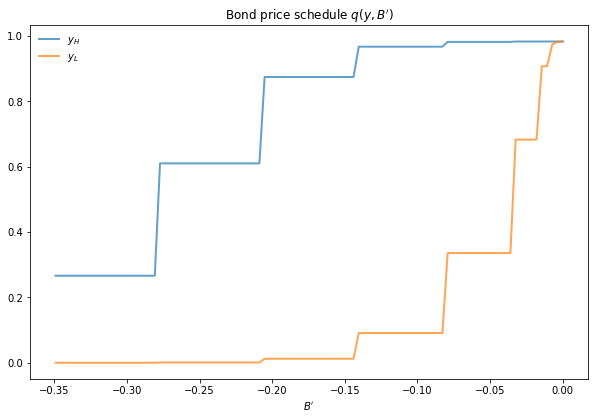

In [24]:
# Create "Y High" and "Y Low" values as 5% devs from mean
high, low = np.mean(ae.ygrid) * 1.05, np.mean(ae.ygrid) * .95
iy_high, iy_low = (np.searchsorted(ae.ygrid, x) for x in (high, low))

fig, ax = plt.subplots(figsize=(10, 6.5))
ax.set_title("Bond price schedule $q(y, B')$")

# Extract a suitable plot grid
x = []
q_low = []
q_high = []
for i in range(ae.nB):
    b = ae.Bgrid[i]
    if -0.35 <= b <= 0:  # To match fig 3 of Arellano
        x.append(b)
        q_low.append(ae.Q[iy_low, i])
        q_high.append(ae.Q[iy_high, i])
ax.plot(x, q_high, label="$y_H$", lw=2, alpha=0.7)
ax.plot(x, q_low, label="$y_L$", lw=2, alpha=0.7)
ax.set_xlabel("$B'$")
ax.legend(loc='upper left', frameon=False)
plt.show()

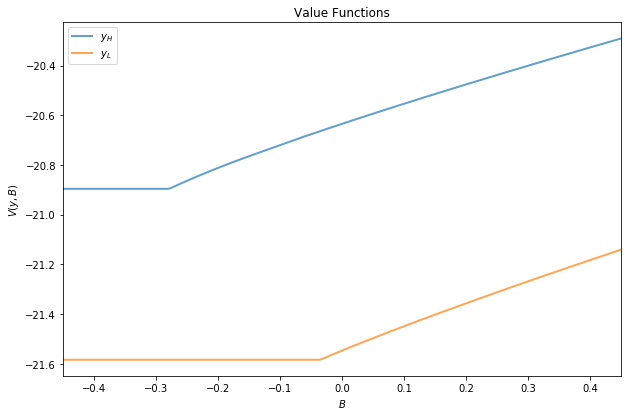

In [25]:
# Create "Y High" and "Y Low" values as 5% devs from mean
high, low = np.mean(ae.ygrid) * 1.05, np.mean(ae.ygrid) * .95
iy_high, iy_low = (np.searchsorted(ae.ygrid, x) for x in (high, low))

fig, ax = plt.subplots(figsize=(10, 6.5))
ax.set_title("Value Functions")
ax.plot(ae.Bgrid, ae.V[iy_high], label="$y_H$", lw=2, alpha=0.7)
ax.plot(ae.Bgrid, ae.V[iy_low], label="$y_L$", lw=2, alpha=0.7)
ax.legend(loc='upper left')
ax.set(xlabel="$B$", ylabel="$V(y, B)$")
ax.set_xlim(ae.Bgrid.min(), ae.Bgrid.max())
plt.show()

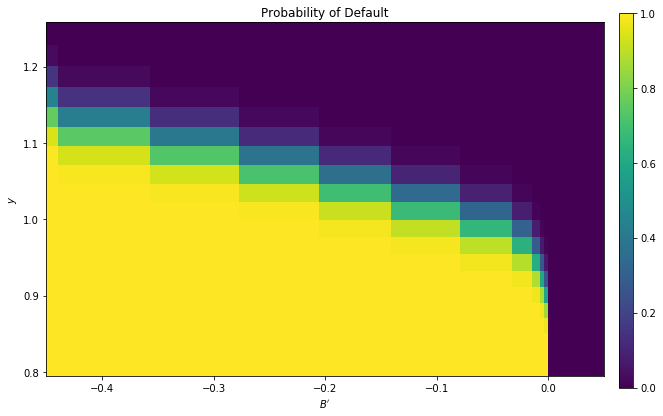

In [26]:
xx, yy = ae.Bgrid, ae.ygrid
zz = ae.default_prob

# Create figure
fig, ax = plt.subplots(figsize=(10, 6.5))
hm = ax.pcolormesh(xx, yy, zz)
cax = fig.add_axes([.92, .1, .02, .8])
fig.colorbar(hm, cax=cax)
ax.axis([xx.min(), 0.05, yy.min(), yy.max()])
ax.set(xlabel="$B'$", ylabel="$y$", title="Probability of Default")
plt.show()

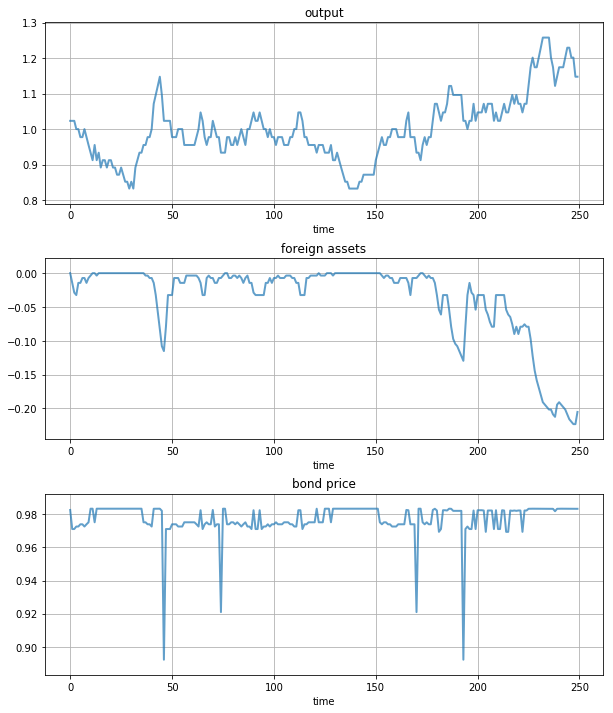

In [27]:
T = 250
y_vec, B_vec, q_vec, default_vec = ae.simulate(T)

# Pick up default start and end dates
start_end_pairs = []
i = 0
while i < len(default_vec):
    if default_vec[i] == 0:
        i += 1
    else:
        # If we get to here we're in default
        start_default = i
        while i < len(default_vec) and default_vec[i] == 1:
            i += 1
        end_default = i - 1
        start_end_pairs.append((start_default, end_default))

plot_series = y_vec, B_vec, q_vec
titles = 'output', 'foreign assets', 'bond price'

fig, axes = plt.subplots(len(plot_series), 1, figsize=(10, 12))
fig.subplots_adjust(hspace=0.3)

for ax, series, title in zip(axes, plot_series, titles):
    # Determine suitable y limits
    s_max, s_min = max(series), min(series)
    s_range = s_max - s_min
    y_max = s_max + s_range * 0.1
    y_min = s_min - s_range * 0.1
    ax.set_ylim(y_min, y_max)
    for pair in start_end_pairs:
        ax.fill_between(pair, (y_min, y_min), (y_max, y_max),
                        color='k', alpha=0.3)
    ax.grid()
    ax.plot(range(T), series, lw=2, alpha=0.7)
    ax.set(title=title, xlabel="time")

plt.show()

#### Lesson: Globalization and Cycles

In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from numba import jit, vectorize
from ipywidgets import interact

In [29]:
@jit(nopython=True)
def _hj(j, nk, s1, s2, θ, δ, ρ):
    """
    If we expand the implicit function for h_j(n_k) then we find that
    it is quadratic. We know that h_j(n_k) > 0 so we can get its
    value by using the quadratic form
    """
    # Find out who's h we are evaluating
    if j == 1:
        sj = s1
        sk = s2
    else:
        sj = s2
        sk = s1

    # Coefficients on the quadratic a x^2 + b x + c = 0
    a = 1.0
    b = ((ρ + 1 / ρ) * nk - sj - sk)
    c = (nk * nk - (sj * nk) / ρ - sk * ρ * nk)

    # Positive solution of quadratic form
    root = (-b + np.sqrt(b * b - 4 * a * c)) / (2 * a)

    return root

@jit(nopython=True)
def DLL(n1, n2, s1_ρ, s2_ρ, s1, s2, θ, δ, ρ):
    "Determine whether (n1, n2) is in the set DLL"
    return (n1 <= s1_ρ) and (n2 <= s2_ρ)

@jit(nopython=True)
def DHH(n1, n2, s1_ρ, s2_ρ, s1, s2, θ, δ, ρ):
    "Determine whether (n1, n2) is in the set DHH"
    return (n1 >= _hj(1, n2, s1, s2, θ, δ, ρ)) and \
           (n2 >= _hj(2, n1, s1, s2, θ, δ, ρ))

@jit(nopython=True)
def DHL(n1, n2, s1_ρ, s2_ρ, s1, s2, θ, δ, ρ):
    "Determine whether (n1, n2) is in the set DHL"
    return (n1 >= s1_ρ) and (n2 <= _hj(2, n1, s1, s2, θ, δ, ρ))

@jit(nopython=True)
def DLH(n1, n2, s1_ρ, s2_ρ, s1, s2, θ, δ, ρ):
    "Determine whether (n1, n2) is in the set DLH"
    return (n1 <= _hj(1, n2, s1, s2, θ, δ, ρ)) and (n2 >= s2_ρ)

@jit(nopython=True)
def one_step(n1, n2, s1_ρ, s2_ρ, s1, s2, θ, δ, ρ):
    """
    Takes a current value for (n_{1, t}, n_{2, t}) and returns the
    values (n_{1, t+1}, n_{2, t+1}) according to the law of motion.
    """
    # Depending on where we are, evaluate the right branch
    if DLL(n1, n2, s1_ρ, s2_ρ, s1, s2, θ, δ, ρ):
        n1_tp1 = δ * (θ * s1_ρ + (1 - θ) * n1)
        n2_tp1 = δ * (θ * s2_ρ + (1 - θ) * n2)
    elif DHH(n1, n2, s1_ρ, s2_ρ, s1, s2, θ, δ, ρ):
        n1_tp1 = δ * n1
        n2_tp1 = δ * n2
    elif DHL(n1, n2, s1_ρ, s2_ρ, s1, s2, θ, δ, ρ):
        n1_tp1 = δ * n1
        n2_tp1 = δ * (θ * _hj(2, n1, s1, s2, θ, δ, ρ) + (1 - θ) * n2)
    elif DLH(n1, n2, s1_ρ, s2_ρ, s1, s2, θ, δ, ρ):
        n1_tp1 = δ * (θ * _hj(1, n2, s1, s2, θ, δ, ρ) + (1 - θ) * n1)
        n2_tp1 = δ * n2

    return n1_tp1, n2_tp1

@jit(nopython=True)
def n_generator(n1_0, n2_0, s1_ρ, s2_ρ, s1, s2, θ, δ, ρ):
    """
    Given an initial condition, continues to yield new values of
    n1 and n2
    """
    n1_t, n2_t = n1_0, n2_0
    while True:
        n1_tp1, n2_tp1 = one_step(n1_t, n2_t, s1_ρ, s2_ρ, s1, s2, θ, δ, ρ)
        yield (n1_tp1, n2_tp1)
        n1_t, n2_t = n1_tp1, n2_tp1

@jit(nopython=True)
def _pers_till_sync(n1_0, n2_0, s1_ρ, s2_ρ, s1, s2, θ, δ, ρ, maxiter, npers):
    """
    Takes initial values and iterates forward to see whether
    the histories eventually end up in sync.

    If countries are symmetric then as soon as the two countries have the
    same measure of firms then they will be synchronized -- However, if
    they are not symmetric then it is possible they have the same measure
    of firms but are not yet synchronized. To address this, we check whether
    firms stay synchronized for `npers` periods with Euclidean norm

    Parameters
    ----------
    n1_0 : scalar(Float)
        Initial normalized measure of firms in country one
    n2_0 : scalar(Float)
        Initial normalized measure of firms in country two
    maxiter : scalar(Int)
        Maximum number of periods to simulate
    npers : scalar(Int)
        Number of periods we would like the countries to have the
        same measure for

    Returns
    -------
    synchronized : scalar(Bool)
        Did the two economies end up synchronized
    pers_2_sync : scalar(Int)
        The number of periods required until they synchronized
    """
    # Initialize the status of synchronization
    synchronized = False
    pers_2_sync = maxiter
    iters = 0

    # Initialize generator
    n_gen = n_generator(n1_0, n2_0, s1_ρ, s2_ρ, s1, s2, θ, δ, ρ)

    # Will use a counter to determine how many times in a row
    # the firm measures are the same
    nsync = 0

    while (not synchronized) and (iters < maxiter):
        # Increment the number of iterations and get next values
        iters += 1
        n1_t, n2_t = next(n_gen)

        # Check whether same in this period
        if abs(n1_t - n2_t) < 1e-8:
            nsync += 1
        # If not, then reset the nsync counter
        else:
            nsync = 0

        # If we have been in sync for npers then stop and countries
        # became synchronized nsync periods ago
        if nsync > npers:
            synchronized = True
            pers_2_sync = iters - nsync

    return synchronized, pers_2_sync

@jit(nopython=True)
def _create_attraction_basis(s1_ρ, s2_ρ, s1, s2, θ, δ, ρ,
        maxiter, npers, npts):
    # Create unit range with npts
    synchronized, pers_2_sync = False, 0
    unit_range = np.linspace(0.0, 1.0, npts)

    # Allocate space to store time to sync
    time_2_sync = np.empty((npts, npts))
    # Iterate over initial conditions
    for (i, n1_0) in enumerate(unit_range):
        for (j, n2_0) in enumerate(unit_range):
            synchronized, pers_2_sync = _pers_till_sync(n1_0, n2_0, s1_ρ,
                                                        s2_ρ, s1, s2, θ, δ,
                                                        ρ, maxiter, npers)
            time_2_sync[i, j] = pers_2_sync

    return time_2_sync


# == Now we define a class for the model == #

class MSGSync:
    """
    The paper "Globalization and Synchronization of Innovation Cycles" presents
    a two-country model with endogenous innovation cycles. Combines elements
    from Deneckere Judd (1985) and Helpman Krugman (1985) to allow for a
    model with trade that has firms who can introduce new varieties into
    the economy.

    We focus on being able to determine whether the two countries eventually
    synchronize their innovation cycles. To do this, we only need a few
    of the many parameters. In particular, we need the parameters listed
    below

    Parameters
    ----------
    s1 : scalar(Float)
        Amount of total labor in country 1 relative to total worldwide labor
    θ : scalar(Float)
        A measure of how much more of the competitive variety is used in
        production of final goods
    δ : scalar(Float)
        Percentage of firms that are not exogenously destroyed every period
    ρ : scalar(Float)
        Measure of how expensive it is to trade between countries
    """
    def __init__(self, s1=0.5, θ=2.5, δ=0.7, ρ=0.2):
        # Store model parameters
        self.s1, self.θ, self.δ, self.ρ = s1, θ, δ, ρ

        # Store other cutoffs and parameters we use
        self.s2 = 1 - s1
        self.s1_ρ = self._calc_s1_ρ()
        self.s2_ρ = 1 - self.s1_ρ

    def _unpack_params(self):
        return self.s1, self.s2, self.θ, self.δ, self.ρ

    def _calc_s1_ρ(self):
        # Unpack params
        s1, s2, θ, δ, ρ = self._unpack_params()

        # s_1(ρ) = min(val, 1)
        val = (s1 - ρ * s2) / (1 - ρ)
        return min(val, 1)

    def simulate_n(self, n1_0, n2_0, T):
        """
        Simulates the values of (n1, n2) for T periods

        Parameters
        ----------
        n1_0 : scalar(Float)
            Initial normalized measure of firms in country one
        n2_0 : scalar(Float)
            Initial normalized measure of firms in country two
        T : scalar(Int)
            Number of periods to simulate

        Returns
        -------
        n1 : Array(Float64, ndim=1)
            A history of normalized measures of firms in country one
        n2 : Array(Float64, ndim=1)
            A history of normalized measures of firms in country two
        """
        # Unpack parameters
        s1, s2, θ, δ, ρ = self._unpack_params()
        s1_ρ, s2_ρ = self.s1_ρ, self.s2_ρ

        # Allocate space
        n1 = np.empty(T)
        n2 = np.empty(T)

        # Create the generator
        n1[0], n2[0] = n1_0, n2_0
        n_gen = n_generator(n1_0, n2_0, s1_ρ, s2_ρ, s1, s2, θ, δ, ρ)

        # Simulate for T periods
        for t in range(1, T):
            # Get next values
            n1_tp1, n2_tp1 = next(n_gen)

            # Store in arrays
            n1[t] = n1_tp1
            n2[t] = n2_tp1

        return n1, n2

    def pers_till_sync(self, n1_0, n2_0, maxiter=500, npers=3):
        """
        Takes initial values and iterates forward to see whether
        the histories eventually end up in sync.

        If countries are symmetric then as soon as the two countries have the
        same measure of firms then they will be synchronized -- However, if
        they are not symmetric then it is possible they have the same measure
        of firms but are not yet synchronized. To address this, we check whether
        firms stay synchronized for `npers` periods with Euclidean norm

        Parameters
        ----------
        n1_0 : scalar(Float)
            Initial normalized measure of firms in country one
        n2_0 : scalar(Float)
            Initial normalized measure of firms in country two
        maxiter : scalar(Int)
            Maximum number of periods to simulate
        npers : scalar(Int)
            Number of periods we would like the countries to have the
            same measure for

        Returns
        -------
        synchronized : scalar(Bool)
            Did the two economies end up synchronized
        pers_2_sync : scalar(Int)
            The number of periods required until they synchronized
        """
        # Unpack parameters
        s1, s2, θ, δ, ρ = self._unpack_params()
        s1_ρ, s2_ρ = self.s1_ρ, self.s2_ρ

        return _pers_till_sync(n1_0, n2_0, s1_ρ, s2_ρ,
                              s1, s2, θ, δ, ρ, maxiter, npers)

    def create_attraction_basis(self, maxiter=250, npers=3, npts=50):
        """
        Creates an attraction basis for values of n on [0, 1] X [0, 1]
        with npts in each dimension
        """
        # Unpack parameters
        s1, s2, θ, δ, ρ = self._unpack_params()
        s1_ρ, s2_ρ = self.s1_ρ, self.s2_ρ

        ab = _create_attraction_basis(s1_ρ, s2_ρ, s1, s2, θ, δ,
                                    ρ, maxiter, npers, npts)

        return ab
    

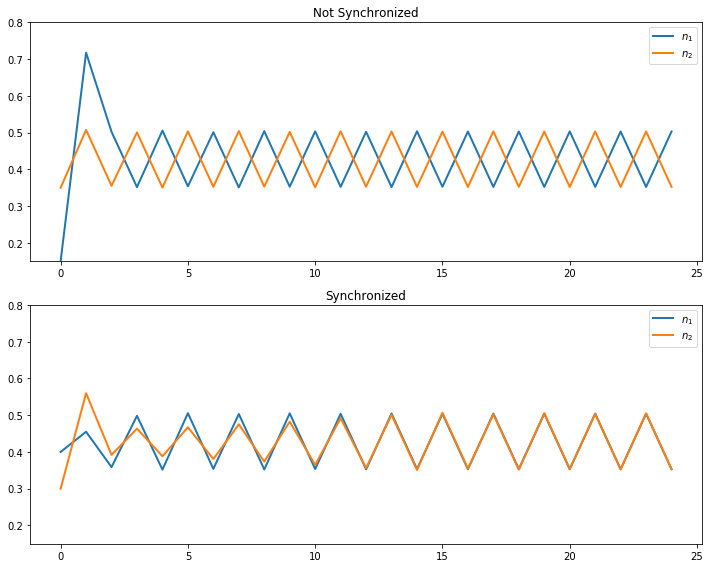

In [30]:
def plot_timeseries(n1_0, n2_0, s1=0.5, θ=2.5,
        δ=0.7, ρ=0.2, ax=None, title=''):
    """
    Plot a single time series with initial conditions
    """
    if ax is None:
        fig, ax = plt.subplots()

    # Create the MSG Model and simulate with initial conditions
    model = MSGSync(s1, θ, δ, ρ)
    n1, n2 = model.simulate_n(n1_0, n2_0, 25)

    ax.plot(np.arange(25), n1, label="$n_1$", lw=2)
    ax.plot(np.arange(25), n2, label="$n_2$", lw=2)

    ax.legend()
    ax.set(title=title, ylim=(0.15, 0.8))

    return ax


# Create figure
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

plot_timeseries(0.15, 0.35, ax=ax[0], title='Not Synchronized')
plot_timeseries(0.4, 0.3, ax=ax[1], title='Synchronized')

fig.tight_layout()

plt.show()



Exercise 1

![Ex1](img/matsuyama_1.png)

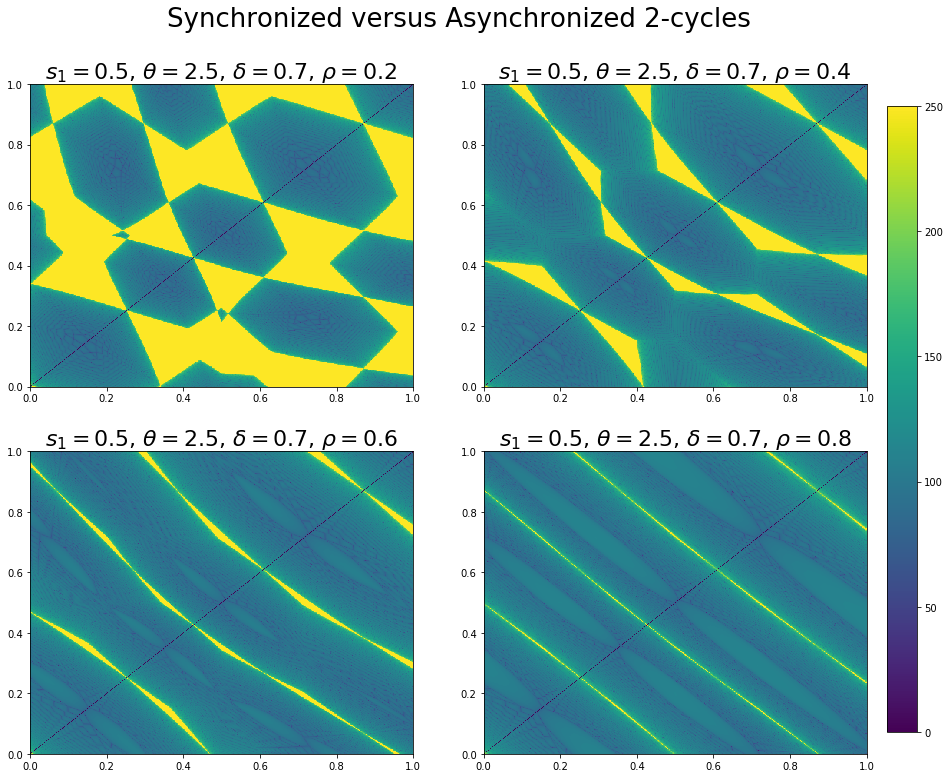

In [31]:
def plot_attraction_basis(s1=0.5, θ=2.5, δ=0.7, ρ=0.2, npts=250, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    # Create attraction basis
    unitrange = np.linspace(0, 1, npts)
    model = MSGSync(s1, θ, δ, ρ)
    ab = model.create_attraction_basis(npts=npts)
    cf = ax.pcolormesh(unitrange, unitrange, ab, cmap="viridis")

    return ab, cf


fig = plt.figure(figsize=(14, 12))

# Left - Bottom - Width - Height
ax0 = fig.add_axes((0.05, 0.475, 0.38, 0.35), label="axes0")
ax1 = fig.add_axes((0.5, 0.475, 0.38, 0.35), label="axes1")
ax2 = fig.add_axes((0.05, 0.05, 0.38, 0.35), label="axes2")
ax3 = fig.add_axes((0.5, 0.05, 0.38, 0.35), label="axes3")

params = [[0.5, 2.5, 0.7, 0.2],
          [0.5, 2.5, 0.7, 0.4],
          [0.5, 2.5, 0.7, 0.6],
          [0.5, 2.5, 0.7, 0.8]]

ab0, cf0 = plot_attraction_basis(*params[0], npts=500, ax=ax0)
ab1, cf1 = plot_attraction_basis(*params[1], npts=500, ax=ax1)
ab2, cf2 = plot_attraction_basis(*params[2], npts=500, ax=ax2)
ab3, cf3 = plot_attraction_basis(*params[3], npts=500, ax=ax3)

cbar_ax = fig.add_axes([0.9, 0.075, 0.03, 0.725])
plt.colorbar(cf0, cax=cbar_ax)

ax0.set_title(r"$s_1=0.5$, $\theta=2.5$, $\delta=0.7$, $\rho=0.2$",
              fontsize=22)
ax1.set_title(r"$s_1=0.5$, $\theta=2.5$, $\delta=0.7$, $\rho=0.4$",
              fontsize=22)
ax2.set_title(r"$s_1=0.5$, $\theta=2.5$, $\delta=0.7$, $\rho=0.6$",
              fontsize=22)
ax3.set_title(r"$s_1=0.5$, $\theta=2.5$, $\delta=0.7$, $\rho=0.8$",
              fontsize=22)

fig.suptitle("Synchronized versus Asynchronized 2-cycles",
             x=0.475, y=0.915, size=26)
plt.show()

In [32]:
def interact_attraction_basis(ρ=0.2, maxiter=250, npts=250):
    # Create the figure and axis that we will plot on
    fig, ax = plt.subplots(figsize=(12, 10))

    # Create model and attraction basis
    s1, θ, δ = 0.5, 2.5, 0.75
    model = MSGSync(s1, θ, δ, ρ)
    ab = model.create_attraction_basis(maxiter=maxiter, npts=npts)

    # Color map with colormesh
    unitrange = np.linspace(0, 1, npts)
    cf = ax.pcolormesh(unitrange, unitrange, ab, cmap="viridis")
    cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
    plt.colorbar(cf, cax=cbar_ax)
    plt.show()
    return None

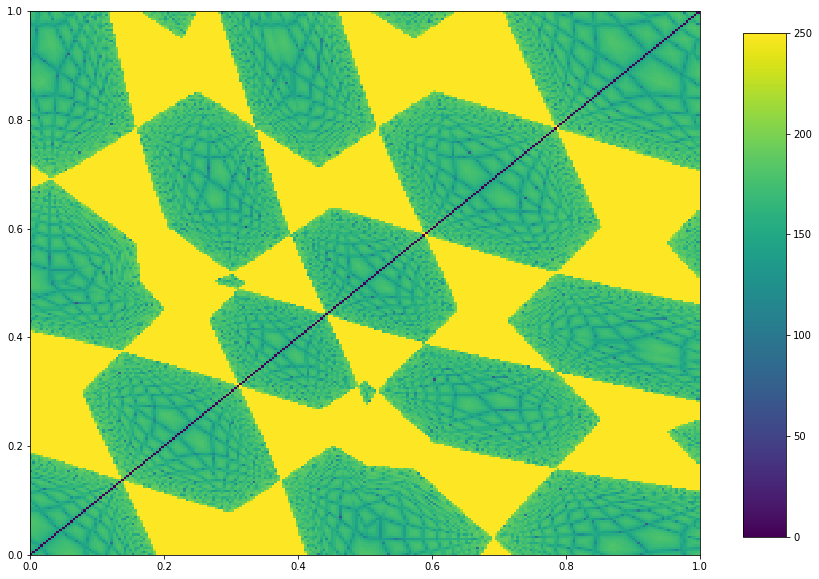

In [34]:
fig = interact(interact_attraction_basis,
               ρ=(0.0, 1.0, 0.05),
               maxiter=(50, 5000, 50),
               npts=(25, 750, 25))